In [1]:
# enabling 3rd party widgets
# from google.colab import output
# output.enable_custom_widget_manager()
# output.disable_custom_widget_manager()

# interactive 3D plot
# !pip install ipympl
# %matplotlib widget

In [2]:
import os
import sys
import math
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

import time as time
import platform as platform

import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import L2
import h5py

from skopt import gp_minimize
from skopt.space import Integer, Real

tf.keras.backend.set_floatx('float32')

In [3]:
colab_flag = False
FTYPE = np.float32
ITYPE = np.int32

array = np.array
float32 = np.float32
int32 = np.int32
float64 = np.float64
int64 = np.int64

strategy = None
# strategy = tf.distribute.MirroredStrategy()

In [4]:
current_sys = platform.system()

if current_sys == 'Windows':
    dir_sep = '\\'
else:
    dir_sep = '/'

In [5]:
if colab_flag == True:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/Github/MLROM/KS/')

In [6]:
print(os.getcwd())

/home/rkaushik/Documents/Thesis/MLROM/new_cdv


In [7]:
from tools.misc_tools import create_data_for_RNN, mytimecallback, SaveLosses, plot_losses, plot_reconstructed_data_KS, plot_latent_states_KS , readAndReturnLossHistories, sigmoidWarmupAndDecayLRSchedule
from tools.ae_v2 import Autoencoder
from tools.ESN_v1 import ESN
from tools.hyper_param_ESN import trainESN_and_return_PH

In [8]:
behaviour = 'initialiseAndTrainFromScratch'
# behaviour = 'loadCheckpointAndContinueTraining'
# behaviour = 'loadFinalNetAndPlot'

In [9]:
# setting seed for PRNGs
if behaviour == 'initialiseAndTrainFromScratch':
    prng_seed = 42
    np.random.seed(prng_seed)
    tf.random.set_seed(prng_seed)

In [10]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)

if colab_flag == False:
    if strategy is None:
        if gpus:
            gpu_to_use = 0
            tf.config.set_visible_devices(gpus[gpu_to_use], 'GPU')
    logical_devices = tf.config.list_logical_devices('GPU')
    print(logical_devices)

2023-06-02 01:00:00.121751: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]


2023-06-02 01:00:00.122035: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-02 01:00:00.155803: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-02 01:00:00.156095: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-02 01:00:00.156322: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-02 01:00:00.156538: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

In [11]:
# print(tf.test.gpu_device_name())
print(tf.config.list_physical_devices())
print(tf.config.list_logical_devices())
print(tf.__version__)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
[LogicalDevice(name='/device:CPU:0', device_type='CPU'), LogicalDevice(name='/device:GPU:0', device_type='GPU')]
2.8.1


# KS System

In [12]:
# setting up params (and saving, if applicable)
# from numpy import *

# making RNN save directory
dir_name_rnn = os.getcwd() + dir_sep + 'ESN_params_Search'
if not os.path.isdir(dir_name_rnn):
    os.makedirs(dir_name_rnn)

counter = 0
while True:
    dir_check = 'params_search_' + str(counter).zfill(3)
    if os.path.isdir(dir_name_rnn + dir_sep + dir_check):
        counter += 1
    else:
        break

dir_name_rnn = dir_name_rnn + dir_sep + dir_check
os.makedirs(dir_name_rnn)
dir_name_rnn_plots = dir_name_rnn+dir_sep+'plots'
os.makedirs(dir_name_rnn_plots)

# whether to use AE data or just work on raw data
use_ae_data = True # if false, specifying ae_idx will only show which dataset to use

# autoencoder directory
# ae_idx = '046'
# dir_name_ae = os.getcwd()+'{ds}saved_ae{ds}ae_'.format(ds=dir_sep)+ae_idx
dir_name_ae = os.getcwd()+'{ds}saved_ae{ds}test_ae_002'.format(ds=dir_sep)

# reading simulation parameters
with open(dir_name_ae + dir_sep + 'ae_data.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
data_dir_idx = params_dict['data_dir_idx']
normalizeforae_flag = params_dict['normalizeforae_flag']
normalization_constant_arr_aedata = params_dict['normalization_constant_arr_aedata']
try:
    ae_data_with_params = params_dict['ae_data_with_params']
except:
    print("'ae_data_with_params' not present in ae_data, set to 'True'.")
    ae_data_with_params = True

if os.path.exists(dir_name_ae+dir_sep+'normalization_data.npz'):
    with np.load(dir_name_ae+dir_sep+'normalization_data.npz', allow_pickle=True) as fl:
        normalization_constant_arr_aedata = fl['normalization_constant_arr_aedata'][0]

print('dir_name_rnn:', dir_name_rnn)
print('use_ae_data : ' + str(use_ae_data) + ', dir_name_ae:', dir_name_ae)
print('data_dir_idx:', data_dir_idx)

# loading data
dir_name_data = os.getcwd() + dir_sep + 'saved_data' + dir_sep + 'data_' + data_dir_idx
    
with open(dir_name_data + dir_sep + 'sim_data_params.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
params_mat = params_dict['params_mat']
# init_state = params_dict['init_state']
t0 = params_dict['t0']
T = params_dict['T']
delta_t = params_dict['delta_t']
return_params_arr = params_dict['return_params_arr']
normalize_flag_ogdata = params_dict['normalize_flag']
print('normalize_flag_ogdata:', normalize_flag_ogdata)
alldata_withparams_flag = params_dict['alldata_withparams_flag']

with np.load(dir_name_data+dir_sep+'data.npz', allow_pickle=True) as fl:
    all_data = fl['all_data'].astype(FTYPE)
    boundary_idx_arr = fl['boundary_idx_arr']
    normalization_constant_arr_ogdata = fl['normalization_constant_arr'][0]
    initial_t0 = fl['initial_t0']
    init_state_mat = fl['init_state_mat']

    lyapunov_spectrum_mat = fl['lyapunov_spectrum_mat']

dir_name_rnn: /home/rkaushik/Documents/Thesis/MLROM/new_cdv/ESN_params_Search/params_search_004
use_ae_data : True, dir_name_ae: /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae/test_ae_002
data_dir_idx: 004
normalize_flag_ogdata: False


In [13]:
lyapunov_time_arr = np.empty(shape=lyapunov_spectrum_mat.shape[0], dtype=FTYPE)
for i in range(lyapunov_spectrum_mat.shape[0]):
    lyapunov_time_arr[i] = 1/lyapunov_spectrum_mat[i, 0]
    print('Case : {}, lyapunov exponent : {}, lyapunov time : {}s'.format(i+1, lyapunov_spectrum_mat[i, 0], lyapunov_time_arr[i]))

Case : 1, lyapunov exponent : 0.027086916024239262, lyapunov time : 36.91819381713867s


In [14]:
positve_lp_idx = np.where(lyapunov_time_arr > 0)[0]
print(positve_lp_idx)

[0]


In [15]:
last_idx = all_data.shape[0]
temp_bia = np.zeros(shape=1+boundary_idx_arr.shape[0], dtype=np.int32)
temp_bia[1:] = boundary_idx_arr
print(temp_bia)
for i in range(boundary_idx_arr.shape[0]-1, -1, -1):
    if not (i in positve_lp_idx):
        print(i)
        num_idxs = last_idx - temp_bia[i+1]
        all_data[temp_bia[i]:temp_bia[i]+num_idxs] = all_data[temp_bia[i+1]:last_idx]
        last_idx = last_idx - (temp_bia[i+1]-temp_bia[i])

[     0 500001]


In [16]:
new_bia = np.empty_like(boundary_idx_arr)
new_bia[:] = boundary_idx_arr
new_pmat = np.empty_like(params_mat)
new_pmat[:, :] = params_mat
counter = 0
bia_counter = boundary_idx_arr.shape[0]
for i in range(boundary_idx_arr.shape[0]):
    if not (i in positve_lp_idx):
        new_bia[i:] -= temp_bia[i+1] - temp_bia[i]
        new_bia[i:bia_counter-1] = new_bia[i+1:bia_counter]
        new_pmat[i:bia_counter-1] = new_pmat[i+1:bia_counter]
        bia_counter -= 1

In [17]:
new_bia = new_bia[0:bia_counter]
new_pmat = new_pmat[0:bia_counter]

In [18]:
all_data = all_data[0:new_bia[-1]]

In [19]:
new_bia, boundary_idx_arr = boundary_idx_arr, new_bia
new_pmat, params_mat = params_mat, new_pmat

In [20]:
# delaing with normalizing the data before feeding into autoencoder
num_params = params_mat.shape[1]
og_vars = all_data.shape[1]
if alldata_withparams_flag == True:
    og_vars -= num_params

if use_ae_data == True:
    if ae_data_with_params == True and alldata_withparams_flag == False:
        new_all_data = np.empty(shape=(all_data.shape[0], og_vars+num_params), dtype=FTYPE)
        new_all_data[:, 0:og_vars] = all_data[:, 0:og_vars]
        del(all_data)
        all_data = new_all_data
        prev_idx = 0
        for i in range(boundary_idx_arr.shape[0]):
            all_data[prev_idx:boundary_idx_arr[i], num_params:] = params_mat[i]
            prev_idx = boundary_idx_arr[i]

    if normalizeforae_flag == True:
        for i in range(all_data.shape[1]):
            all_data[:, i] -= normalization_constant_arr_aedata[0, i]
            all_data[:, i] /= normalization_constant_arr_aedata[1, i]

    if ae_data_with_params == False:
        all_data = all_data[:, 0:og_vars]
else:
    # using raw data, neglecting the params attached (if any)
    all_data = all_data[:, 0:og_vars]

# Autoencoder

In [21]:
if use_ae_data == True:
    load_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_class_dict.txt'
    wt_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_ae_weights.h5'

In [22]:
if use_ae_data == True:
    ae_net = Autoencoder(all_data.shape[1], load_file=load_file)
    ae_net.load_weights_from_file(wt_file)

In [23]:
# create data
if use_ae_data == True:
    latent_states_all = ae_net.encoder_net.predict(all_data)
    del(all_data)
else:
    latent_states_all = all_data
num_latent_states = latent_states_all.shape[1]

In [24]:
latent_states_all.shape

(500001, 5)

# ESN

In [25]:
# RNN data parameters
dt_rnn = 0.1
num_input_tsteps = 25000
T_sample_input = num_input_tsteps*dt_rnn
T_sample_output = T_sample_input
T_offset = dt_rnn
normalize_dataset = True # whether the data for the RNN should be normalized by the dataset's mean and std
normalization_arr = None
stddev_multiplier = 3
skip_intermediate = 'full sample'
noise_type = 'normal' # can be 'uniform' or 'normal'
normalization_type = 'stddev' # can be 'minmax' or 'stddev', if it is
                              # 'minmax' then stddev_multiplier has no effect
ESN_layers_units = [num_latent_states*200]
stateful = True
omega_in_x0 = 1.0
degree_of_connectivity_x0 = 3
rho_res_x0 = 0.8
usebias_Win = [False]
alpha_x0 = 0.99
ESN_cell_activations = ['tanh']
usebias_Wout = True

activation_post_Wout = 'linear'
use_weights_post_dense = False


if return_params_arr != False:
    params = params_arr
else:
    params = None

# saving simulation data
sim_data = {
    'params_mat':params_mat,
    'init_state_mat':init_state_mat,
    't0':t0,
    'T':T,
    'delta_t':delta_t,
    'return_params_arr':return_params_arr,
    'dir_name_ae':dir_name_ae,
    'normalize_dataset':normalize_dataset,
    'stddev_multiplier':stddev_multiplier,
    'use_ae_data':use_ae_data,
}

# saving RNN specific data
RNN_specific_data = {
    'dt_rnn':dt_rnn,
    'T_sample_input':T_sample_input,
    'T_sample_output':T_sample_output,
    'T_offset':T_offset,
    'boundary_idx_arr':boundary_idx_arr,
    'delta_t':delta_t,
    'params':params,
    'return_params_arr':return_params_arr,
    'normalize_dataset':normalize_dataset,
    'num_input_tsteps':num_input_tsteps,
    'stddev_multiplier':stddev_multiplier,
    'skip_intermediate':skip_intermediate,
    'module':ESN.__module__,
    'noise_type':noise_type,
    'normalization_type':normalization_type,
}

In [26]:
rnn_res_dict = create_data_for_RNN(
    latent_states_all,
    dt_rnn,
    T_sample_input,
    T_sample_output,
    T_offset,
    None,
    boundary_idx_arr,
    delta_t,
    params=params,
    return_numsamples=True,
    normalize_dataset=normalize_dataset,
    stddev_multiplier=stddev_multiplier,
    skip_intermediate=skip_intermediate,
    return_OrgDataIdxArr=False,
    normalization_arr_external=normalization_arr,
    normalization_type=normalization_type,
    FTYPE=FTYPE,
    ITYPE=ITYPE)
    
data_rnn_input = rnn_res_dict['data_rnn_input']
data_rnn_output = rnn_res_dict['data_rnn_output']
org_data_idx_arr_input = rnn_res_dict['org_data_idx_arr_input']
org_data_idx_arr_output = rnn_res_dict['org_data_idx_arr_output']
num_samples = rnn_res_dict['num_samples']
normalization_arr = rnn_res_dict['normalization_arr']
rnn_data_boundary_idx_arr = rnn_res_dict['rnn_data_boundary_idx_arr']

In [27]:
temp = np.divide(latent_states_all-normalization_arr[0], normalization_arr[1])
time_stddev = np.std(temp, axis=0)
timeMeanofSpaceRMS = np.mean(np.mean(temp**2, axis=1)**0.5)
del(org_data_idx_arr_input)
del(org_data_idx_arr_output)
del(latent_states_all)
del(temp)

In [28]:
# setting up training params
num_ensemble_mems = 5
epochs = 1
lambda_reg_x0 = 1e-5 # weight for regularizer
min_delta = 1e-6
patience = 5
train_split = 0.8
val_split = 0.1
test_split = 1 - train_split - val_split
batch_size = 1
fRMS_x0 = 1/100
use_best = False

# ph computation parameters
num_runs = 50
T_sample_input_AR_ratio = 1
T_sample_output_AR_ratio = 5

# saving training params
training_specific_params = {
    'epochs':epochs,
    'prng_seed':prng_seed,
    'train_split':train_split,
    'val_split':val_split,
    'batch_size':batch_size,
    # 'fRMS':fRMS,
    'timeMeanofSpaceRMS':timeMeanofSpaceRMS,
    # 'stddev':stddev,
    # 'lambda_reg':lambda_reg,
    'min_delta':min_delta,
    'patience':patience,
    'use_best':use_best,
}

In [30]:
cum_samples = rnn_data_boundary_idx_arr[-1]
# idx = np.arange(cum_samples)
# np.random.shuffle(idx)
num_train = 0
num_val = 0
begin_idx = 0
for i in range(len(boundary_idx_arr)):
    num_samples = rnn_data_boundary_idx_arr[i] - begin_idx
    num_train += int( np.round(train_split*num_samples) )
    num_val += int( np.round(val_split*num_samples) )
    begin_idx = rnn_data_boundary_idx_arr[i]

# defining shapes
training_input_shape = [num_train]
training_input_shape.extend(data_rnn_input.shape[1:])

training_output_shape = [num_train]
training_output_shape.extend(data_rnn_output.shape[1:])

val_input_shape = [num_val]
val_input_shape.extend(data_rnn_input.shape[1:])

val_output_shape = [num_train]
val_output_shape.extend(data_rnn_output.shape[1:])

testing_input_shape = [cum_samples-num_train-num_val]
testing_input_shape.extend(data_rnn_input.shape[1:])

testing_output_shape = [cum_samples-num_train-num_val]
testing_output_shape.extend(data_rnn_output.shape[1:])

# defining required arrays
training_data_rnn_input = np.empty(shape=training_input_shape, dtype=FTYPE)
training_data_rnn_output = np.empty(shape=training_output_shape, dtype=FTYPE)

val_data_rnn_input = np.empty(shape=val_input_shape, dtype=FTYPE)
val_data_rnn_output = np.empty(shape=val_output_shape, dtype=FTYPE)

testing_data_rnn_input = np.empty(shape=testing_input_shape, dtype=FTYPE)
testing_data_rnn_output = np.empty(shape=testing_output_shape, dtype=FTYPE)

begin_idx = 0
training_data_rolling_count = 0
val_data_rolling_count = 0
testing_data_rolling_count = 0
for i in range(len(boundary_idx_arr)):
    idx = np.arange(begin_idx, rnn_data_boundary_idx_arr[i])
    # np.random.shuffle(idx)
    num_samples = idx.shape[0]
    num_train = int( np.round(train_split*num_samples) )
    num_val = int( np.round(val_split*num_samples) )

    training_data_rnn_input[training_data_rolling_count:training_data_rolling_count+num_train] = data_rnn_input[idx[0:num_train]]
    training_data_rnn_output[training_data_rolling_count:training_data_rolling_count+num_train] = data_rnn_output[idx[0:num_train]]
    training_data_rolling_count += num_train

    val_data_rnn_input[val_data_rolling_count:val_data_rolling_count+num_val] = data_rnn_input[idx[num_train:num_train+num_val]]
    val_data_rnn_output[val_data_rolling_count:val_data_rolling_count+num_val] = data_rnn_output[idx[num_train:num_train+num_val]]
    val_data_rolling_count += num_val

    num_test = num_samples-num_train-num_val+1
    testing_data_rnn_input[testing_data_rolling_count:testing_data_rolling_count+num_test] = data_rnn_input[idx[num_train+num_val:]]
    testing_data_rnn_output[testing_data_rolling_count:testing_data_rolling_count+num_test] = data_rnn_output[idx[num_train+num_val:]]
    testing_data_rolling_count += num_test

    begin_idx = rnn_data_boundary_idx_arr[i]

# cleaning up
del(data_rnn_input)
del(data_rnn_output)

# further shuffling
# idx = np.arange(0, training_data_rnn_input.shape[0])
# np.random.shuffle(idx)
# training_data_rnn_input = training_data_rnn_input[idx]
# training_data_rnn_output = training_data_rnn_output[idx]

# idx = np.arange(0, val_data_rnn_input.shape[0])
# np.random.shuffle(idx)
# val_data_rnn_input = val_data_rnn_input[idx]
# val_data_rnn_output = val_data_rnn_output[idx]

# idx = np.arange(0, testing_data_rnn_input.shape[0])
# np.random.shuffle(idx)
# testing_data_rnn_input = testing_data_rnn_input[idx]
# testing_data_rnn_output = testing_data_rnn_output[idx]

# del(idx)

In [31]:
print('training_data_rnn_input.shape : ', training_data_rnn_input.shape)
print(' testing_data_rnn_input.shape : ', testing_data_rnn_input.shape)
print('     val_data_rnn_input.shape : ', val_data_rnn_input.shape)

training_data_rnn_input.shape :  (15, 25000, 5)
 testing_data_rnn_input.shape :  (2, 25000, 5)
     val_data_rnn_input.shape :  (2, 25000, 5)


In [32]:
val_loss_hist = []
train_loss_hist = []

In [33]:
training_data_rnn_input.dtype

dtype('float32')

In [34]:
def optim_func(
        x, # [fRMS, lambda_reg, rho_res, omega_in, alpha, degree_of_connectivity]
        time_stddev=time_stddev,
        og_vars=og_vars,
        ESN=ESN,
        plot_losses=plot_losses,
        dir_name_rnn=dir_name_rnn,
        boundary_idx_arr=boundary_idx_arr,
        lyapunov_time_arr=lyapunov_time_arr,
        sim_data_dict=sim_data,
        RNN_specific_data_dict=RNN_specific_data,
        training_specific_params_dict=training_specific_params,
        normalization_arr=normalization_arr,
        training_data_rnn_input=training_data_rnn_input,
        training_data_rnn_output=training_data_rnn_output,
        testing_data_rnn_input=testing_data_rnn_input,
        testing_data_rnn_output=testing_data_rnn_output,
        val_data_rnn_input=val_data_rnn_input,
        val_data_rnn_output=val_data_rnn_output,
        return_params_arr=return_params_arr,
        normalize_dataset=normalize_dataset,
        dt_rnn=dt_rnn,
        noise_type=noise_type,
        num_ensemble_mems=num_ensemble_mems,
        ESN_layers_units=ESN_layers_units,
        stateful=stateful,
        usebias_Win=usebias_Win,
        ESN_cell_activations=ESN_cell_activations,
        usebias_Wout=usebias_Wout,
        activation_post_Wout=activation_post_Wout,
        use_weights_post_dense=use_weights_post_dense,
        prng_seed=prng_seed,
        epochs=epochs,
        patience=patience,  # parameter for early stopping
        min_delta=min_delta,  # parameter for early stopping
        batch_size=batch_size,
        num_runs=num_runs,
        T_sample_input_AR_ratio=T_sample_input_AR_ratio,
        T_sample_output_AR_ratio=T_sample_output_AR_ratio,
        use_best=use_best,
    ):
    
    median_PH = trainESN_and_return_PH(
        x, # [fRMS, lambda_reg, rho_res, omega_in, alpha, degree_of_connectivity]
        time_stddev,
        og_vars,
        ESN,
        plot_losses,
        dir_name_rnn,
        boundary_idx_arr,
        lyapunov_time_arr,
        sim_data_dict,
        RNN_specific_data_dict,
        training_specific_params_dict,
        normalization_arr,
        training_data_rnn_input,
        training_data_rnn_output,
        testing_data_rnn_input,
        testing_data_rnn_output,
        val_data_rnn_input,
        val_data_rnn_output,
        return_params_arr,
        normalize_dataset,
        dt_rnn,
        noise_type,
        num_ensemble_mems=num_ensemble_mems,
        ESN_layers_units=ESN_layers_units,
        stateful=stateful,
        usebias_Win=usebias_Win,
        ESN_cell_activations=ESN_cell_activations,
        usebias_Wout=usebias_Wout,
        activation_post_Wout=activation_post_Wout,
        use_weights_post_dense=use_weights_post_dense,
        prng_seed=prng_seed,
        epochs=epochs,
        patience=patience,  # parameter for early stopping
        min_delta=min_delta,  # parameter for early stopping
        batch_size=batch_size,
        num_runs=num_runs,
        T_sample_input_AR_ratio=T_sample_input_AR_ratio,
        T_sample_output_AR_ratio=T_sample_output_AR_ratio,
        use_best=use_best,
    )
    
    return -median_PH

In [35]:
fRMS_bounds = Real(0.1/100, 10/100, "log-uniform")
lambda_reg_bounds = Real(1e-7, 1e-3, "log-uniform")
rho_res_bounds = Real(0.2, 0.95)
omega_in_bounds = Real(0.5, 1.5)
alpha_bounds = Real(0.5, 1.0)
degree_of_connectivity_bounds = Integer(1, 10)
n_calls = 50
acq_func = "EI"
n_initial_points = 10
n_calls += n_initial_points

optim_dict = {
    'fRMS_bounds':fRMS_bounds,
    'lambda_reg_bounds':lambda_reg_bounds,
    'rho_res_bounds':rho_res_bounds,
    'omega_in_bounds':omega_in_bounds,
    'alpha_bounds':alpha_bounds,
    'degree_of_connectivity_bounds':degree_of_connectivity_bounds,
    'n_calls':n_calls,
    'acq_func':acq_func,
    'n_initial_points':n_initial_points,
    'random_state':prng_seed,
}
with open(dir_name_rnn + '/optim_params.txt', 'w') as f:
    f.write(str(optim_dict))
    
dimensions = [
    fRMS_bounds,
    lambda_reg_bounds,
    rho_res_bounds,
    omega_in_bounds,
    alpha_bounds,
    degree_of_connectivity_bounds
]

In [36]:
res = gp_minimize(
    optim_func,
    dimensions,
    x0=[1e-3, 1e-7, rho_res_x0, omega_in_x0, alpha_x0, degree_of_connectivity_x0],
    n_calls=n_calls,
    n_initial_points=n_initial_points,
    random_state=prng_seed,
    acq_func=acq_func,
)

--- ENSEMBLE MEMBER 1/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 15 -- Wout batch_time : 2.96 s -- eta : 0h 0m 41s
2 / 15 -- Wout batch_time : 3.17 s -- eta : 0h 0m 40s
3 / 15 -- Wout batch_time : 3.07 s -- eta : 0h 0m 37s
4 / 15 -- Wout batch_time : 2.99 s -- eta : 0h 0m 34s
5 / 15 -- Wout batch_time : 2.90 s -- eta : 0h 0m 30s
6 / 15 -- Wout batch_time : 3.36 s -- eta : 0h 0m 28s
7 / 15 -- Wout batch_time : 3.24 s -- eta : 0h 0m 25s
8 / 15 -- Wout batch_time : 3.07 s -- eta : 0h 0m 22s
9 / 15 -- Wout batch_time : 2.98 s -- eta : 0h 0m 19s
10 / 15 -- Wout batch_time : 2.96 s -- eta : 0h 0m 15s
11 / 15 -- Wout batch_time : 3.13 s -- eta : 0h 0m 12s
12 / 15 -- Wout batch_time : 3.11 s -- eta : 0h 0m 9s
13 / 15 -- Wout batch_time : 3.00 s -- eta : 0h 0m 6s
14 / 15 -- Wout bat

14 / 15 -- batch_time : 2.753998279571533 sec
15 / 15 -- batch_time : 2.5189738273620605 sec

train_mse : 8.887086059653865e-09
val_mse : 2.435906388154052e-06
val_mse improved from inf

Total epoch computation time : 89.88879132270813 sec

test mse
1 / 2
2 / 2
test_mse : 3.4671059498947443e-06
--- ENSEMBLE MEMBER 5/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 15 -- Wout batch_time : 3.33 s -- eta : 0h 0m 47s
2 / 15 -- Wout batch_time : 3.17 s -- eta : 0h 0m 42s
3 / 15 -- Wout batch_time : 2.84 s -- eta : 0h 0m 37s
4 / 15 -- Wout batch_time : 2.87 s -- eta : 0h 0m 34s
5 / 15 -- Wout batch_time : 2.93 s -- eta : 0h 0m 30s
6 / 15 -- Wout batch_time : 2.96 s -- eta : 0h 0m 27s
7 / 15 -- Wout batch_time : 3.04 s -- eta : 0h 0m 24s
8 / 15 -- Wout batch_time : 3.03 s -- eta : 0h 0m

2 / 2
test_mse : 6.217504576966348e-06
--- ENSEMBLE MEMBER 3/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 15 -- Wout batch_time : 3.17 s -- eta : 0h 0m 44s
2 / 15 -- Wout batch_time : 3.12 s -- eta : 0h 0m 41s
3 / 15 -- Wout batch_time : 3.02 s -- eta : 0h 0m 37s
4 / 15 -- Wout batch_time : 2.96 s -- eta : 0h 0m 34s
5 / 15 -- Wout batch_time : 2.93 s -- eta : 0h 0m 30s
6 / 15 -- Wout batch_time : 3.09 s -- eta : 0h 0m 27s
7 / 15 -- Wout batch_time : 3.25 s -- eta : 0h 0m 25s
8 / 15 -- Wout batch_time : 2.99 s -- eta : 0h 0m 21s
9 / 15 -- Wout batch_time : 2.96 s -- eta : 0h 0m 18s
10 / 15 -- Wout batch_time : 2.86 s -- eta : 0h 0m 15s
11 / 15 -- Wout batch_time : 2.89 s -- eta : 0h 0m 12s
12 / 15 -- Wout batch_time : 3.37 s -- eta : 0h 0m 9s
13 / 15 -- Wout batch_time : 3.01 

6 / 15 -- batch_time : 2.7582945823669434 sec
7 / 15 -- batch_time : 2.723313331604004 sec
8 / 15 -- batch_time : 2.7544803619384766 sec
9 / 15 -- batch_time : 2.6929636001586914 sec
10 / 15 -- batch_time : 2.5618698596954346 sec
11 / 15 -- batch_time : 2.5893747806549072 sec
12 / 15 -- batch_time : 2.612287998199463 sec
13 / 15 -- batch_time : 2.8473098278045654 sec
14 / 15 -- batch_time : 2.555279493331909 sec
15 / 15 -- batch_time : 2.731781244277954 sec

train_mse : 6.679634599512001e-08
val_mse : 3.5585282844863286e-06
val_mse improved from inf

Total epoch computation time : 91.43921756744385 sec

test mse
1 / 2
2 / 2
test_mse : 3.4691991110946674e-06
--- ENSEMBLE MEMBER 2/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 15 -- Wout batch_time : 3.14 s -- eta : 0h 0m 44s
2 /

2 / 2 -- batch_time : 2.751448392868042 sec

training mse
1 / 15 -- batch_time : 2.6093719005584717 sec
2 / 15 -- batch_time : 2.7406210899353027 sec
3 / 15 -- batch_time : 2.9955835342407227 sec
4 / 15 -- batch_time : 2.6173317432403564 sec
5 / 15 -- batch_time : 2.6310434341430664 sec
6 / 15 -- batch_time : 2.6736509799957275 sec
7 / 15 -- batch_time : 2.584028482437134 sec
8 / 15 -- batch_time : 2.7392959594726562 sec
9 / 15 -- batch_time : 2.574653148651123 sec
10 / 15 -- batch_time : 2.5951709747314453 sec
11 / 15 -- batch_time : 2.518005847930908 sec
12 / 15 -- batch_time : 2.8041493892669678 sec
13 / 15 -- batch_time : 2.735460042953491 sec
14 / 15 -- batch_time : 2.5198423862457275 sec
15 / 15 -- batch_time : 2.561938524246216 sec

train_mse : 6.671535454453681e-08
val_mse : 2.971298126652755e-06
val_mse improved from inf

Total epoch computation time : 90.44601035118103 sec

test mse
1 / 2
2 / 2
test_mse : 3.370466615137957e-06
tested_ESN/test_ESN_002
num_runs : 50

error_thre

6 / 15 -- Wout batch_time : 3.07 s -- eta : 0h 0m 28s
7 / 15 -- Wout batch_time : 3.00 s -- eta : 0h 0m 24s
8 / 15 -- Wout batch_time : 2.92 s -- eta : 0h 0m 21s
9 / 15 -- Wout batch_time : 2.95 s -- eta : 0h 0m 18s
10 / 15 -- Wout batch_time : 2.91 s -- eta : 0h 0m 15s
11 / 15 -- Wout batch_time : 3.17 s -- eta : 0h 0m 12s
12 / 15 -- Wout batch_time : 3.02 s -- eta : 0h 0m 9s
13 / 15 -- Wout batch_time : 2.92 s -- eta : 0h 0m 6s
14 / 15 -- Wout batch_time : 3.08 s -- eta : 0h 0m 3s
15 / 15 -- Wout batch_time : 3.00 s -- eta : 0h 0m 0s

epoch_time : 45.64691138267517 sec

val mse
1 / 2 -- batch_time : 2.6260952949523926 sec
2 / 2 -- batch_time : 2.5123543739318848 sec

training mse
1 / 15 -- batch_time : 2.7737114429473877 sec
2 / 15 -- batch_time : 2.684216260910034 sec
3 / 15 -- batch_time : 2.677417278289795 sec
4 / 15 -- batch_time : 2.5025837421417236 sec
5 / 15 -- batch_time : 2.718968629837036 sec
6 / 15 -- batch_time : 2.762874126434326 sec
7 / 15 -- batch_time : 2.736292600631

2 / 2
test_mse : 8.567550016103098e-07
--- ENSEMBLE MEMBER 3/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 15 -- Wout batch_time : 3.53 s -- eta : 0h 0m 49s
2 / 15 -- Wout batch_time : 2.94 s -- eta : 0h 0m 42s
3 / 15 -- Wout batch_time : 3.11 s -- eta : 0h 0m 38s
4 / 15 -- Wout batch_time : 3.16 s -- eta : 0h 0m 35s
5 / 15 -- Wout batch_time : 2.95 s -- eta : 0h 0m 31s
6 / 15 -- Wout batch_time : 2.92 s -- eta : 0h 0m 28s
7 / 15 -- Wout batch_time : 3.05 s -- eta : 0h 0m 25s
8 / 15 -- Wout batch_time : 2.88 s -- eta : 0h 0m 21s
9 / 15 -- Wout batch_time : 3.24 s -- eta : 0h 0m 19s
10 / 15 -- Wout batch_time : 2.92 s -- eta : 0h 0m 15s
11 / 15 -- Wout batch_time : 2.94 s -- eta : 0h 0m 12s
12 / 15 -- Wout batch_time : 3.19 s -- eta : 0h 0m 9s
13 / 15 -- Wout batch_time : 3.00 

6 / 15 -- batch_time : 2.5892856121063232 sec
7 / 15 -- batch_time : 2.7639236450195312 sec
8 / 15 -- batch_time : 2.643796682357788 sec
9 / 15 -- batch_time : 2.901552677154541 sec
10 / 15 -- batch_time : 2.907343864440918 sec
11 / 15 -- batch_time : 2.7724123001098633 sec
12 / 15 -- batch_time : 2.6294658184051514 sec
13 / 15 -- batch_time : 2.635758399963379 sec
14 / 15 -- batch_time : 2.7476186752319336 sec
15 / 15 -- batch_time : 2.574427843093872 sec

train_mse : 9.500490912491461e-09
val_mse : 2.135977542394585e-06
val_mse improved from inf

Total epoch computation time : 92.5510025024414 sec

test mse
1 / 2
2 / 2
test_mse : 2.26998442687254e-06
--- ENSEMBLE MEMBER 2/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 15 -- Wout batch_time : 3.12 s -- eta : 0h 0m 44s
2 / 15 -

2 / 2 -- batch_time : 2.5347306728363037 sec

training mse
1 / 15 -- batch_time : 2.6438605785369873 sec
2 / 15 -- batch_time : 3.0883729457855225 sec
3 / 15 -- batch_time : 2.656331777572632 sec
4 / 15 -- batch_time : 2.690778970718384 sec
5 / 15 -- batch_time : 2.6204423904418945 sec
6 / 15 -- batch_time : 2.6822657585144043 sec
7 / 15 -- batch_time : 2.5439260005950928 sec
8 / 15 -- batch_time : 2.6455297470092773 sec
9 / 15 -- batch_time : 2.493800640106201 sec
10 / 15 -- batch_time : 2.76834774017334 sec
11 / 15 -- batch_time : 2.774566173553467 sec
12 / 15 -- batch_time : 2.6961071491241455 sec
13 / 15 -- batch_time : 2.8349525928497314 sec
14 / 15 -- batch_time : 2.6204991340637207 sec
15 / 15 -- batch_time : 2.520449638366699 sec

train_mse : 9.418854733193411e-09
val_mse : 1.7444742770322819e-06
val_mse improved from inf

Total epoch computation time : 92.16038942337036 sec

test mse
1 / 2
2 / 2
test_mse : 2.2006490651982347e-06
tested_ESN/test_ESN_005
num_runs : 50

error_thr

6 / 15 -- Wout batch_time : 2.99 s -- eta : 0h 0m 27s
7 / 15 -- Wout batch_time : 3.16 s -- eta : 0h 0m 24s
8 / 15 -- Wout batch_time : 3.06 s -- eta : 0h 0m 21s
9 / 15 -- Wout batch_time : 2.91 s -- eta : 0h 0m 18s
10 / 15 -- Wout batch_time : 2.94 s -- eta : 0h 0m 15s
11 / 15 -- Wout batch_time : 3.24 s -- eta : 0h 0m 12s
12 / 15 -- Wout batch_time : 2.95 s -- eta : 0h 0m 9s
13 / 15 -- Wout batch_time : 3.04 s -- eta : 0h 0m 6s
14 / 15 -- Wout batch_time : 3.00 s -- eta : 0h 0m 3s
15 / 15 -- Wout batch_time : 3.00 s -- eta : 0h 0m 0s

epoch_time : 45.40662455558777 sec

val mse
1 / 2 -- batch_time : 2.733440637588501 sec
2 / 2 -- batch_time : 2.5933115482330322 sec

training mse
1 / 15 -- batch_time : 2.7092888355255127 sec
2 / 15 -- batch_time : 2.665926456451416 sec
3 / 15 -- batch_time : 2.632823944091797 sec
4 / 15 -- batch_time : 2.645082950592041 sec
5 / 15 -- batch_time : 2.799809217453003 sec
6 / 15 -- batch_time : 2.5935752391815186 sec
7 / 15 -- batch_time : 2.6524188518524

2 / 2
test_mse : 1.379993841865712e-06
--- ENSEMBLE MEMBER 3/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 15 -- Wout batch_time : 3.30 s -- eta : 0h 0m 46s
2 / 15 -- Wout batch_time : 2.98 s -- eta : 0h 0m 41s
3 / 15 -- Wout batch_time : 3.06 s -- eta : 0h 0m 37s
4 / 15 -- Wout batch_time : 3.16 s -- eta : 0h 0m 34s
5 / 15 -- Wout batch_time : 3.16 s -- eta : 0h 0m 31s
6 / 15 -- Wout batch_time : 2.91 s -- eta : 0h 0m 28s
7 / 15 -- Wout batch_time : 2.90 s -- eta : 0h 0m 25s
8 / 15 -- Wout batch_time : 2.95 s -- eta : 0h 0m 21s
9 / 15 -- Wout batch_time : 3.01 s -- eta : 0h 0m 18s
10 / 15 -- Wout batch_time : 3.04 s -- eta : 0h 0m 15s
11 / 15 -- Wout batch_time : 2.94 s -- eta : 0h 0m 12s
12 / 15 -- Wout batch_time : 2.86 s -- eta : 0h 0m 9s
13 / 15 -- Wout batch_time : 3.15 

6 / 15 -- batch_time : 2.676020860671997 sec
7 / 15 -- batch_time : 2.739187002182007 sec
8 / 15 -- batch_time : 2.7119557857513428 sec
9 / 15 -- batch_time : 2.641235113143921 sec
10 / 15 -- batch_time : 2.594675302505493 sec
11 / 15 -- batch_time : 2.639180898666382 sec
12 / 15 -- batch_time : 2.6754531860351562 sec
13 / 15 -- batch_time : 2.945173501968384 sec
14 / 15 -- batch_time : 2.79528546333313 sec
15 / 15 -- batch_time : 2.536926031112671 sec

train_mse : 1.65206188877202e-08
val_mse : 1.9879013901658027e-06
val_mse improved from inf

Total epoch computation time : 92.78635621070862 sec

test mse
1 / 2
2 / 2
test_mse : 2.0556340438737664e-06
--- ENSEMBLE MEMBER 2/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 15 -- Wout batch_time : 2.94 s -- eta : 0h 0m 41s
2 / 15 --

2 / 2 -- batch_time : 2.637275218963623 sec

training mse
1 / 15 -- batch_time : 2.703366279602051 sec
2 / 15 -- batch_time : 2.942795515060425 sec
3 / 15 -- batch_time : 2.5483481884002686 sec
4 / 15 -- batch_time : 2.6801435947418213 sec
5 / 15 -- batch_time : 2.722332000732422 sec
6 / 15 -- batch_time : 2.643328905105591 sec
7 / 15 -- batch_time : 2.6880998611450195 sec
8 / 15 -- batch_time : 2.665955066680908 sec
9 / 15 -- batch_time : 2.50840425491333 sec
10 / 15 -- batch_time : 2.815523147583008 sec
11 / 15 -- batch_time : 2.687579393386841 sec
12 / 15 -- batch_time : 2.736715078353882 sec
13 / 15 -- batch_time : 2.642272472381592 sec
14 / 15 -- batch_time : 2.519070625305176 sec
15 / 15 -- batch_time : 2.971212387084961 sec

train_mse : 1.6902646216010457e-08
val_mse : 1.8355177076045948e-06
val_mse improved from inf

Total epoch computation time : 90.50245451927185 sec

test mse
1 / 2
2 / 2
test_mse : 2.012916735072423e-06
tested_ESN/test_ESN_008
num_runs : 50

error_threshold 

6 / 15 -- Wout batch_time : 3.18 s -- eta : 0h 0m 27s
7 / 15 -- Wout batch_time : 3.07 s -- eta : 0h 0m 24s
8 / 15 -- Wout batch_time : 3.03 s -- eta : 0h 0m 21s
9 / 15 -- Wout batch_time : 3.06 s -- eta : 0h 0m 18s
10 / 15 -- Wout batch_time : 3.09 s -- eta : 0h 0m 15s
11 / 15 -- Wout batch_time : 3.12 s -- eta : 0h 0m 12s
12 / 15 -- Wout batch_time : 3.14 s -- eta : 0h 0m 9s
13 / 15 -- Wout batch_time : 2.96 s -- eta : 0h 0m 6s
14 / 15 -- Wout batch_time : 2.95 s -- eta : 0h 0m 3s
15 / 15 -- Wout batch_time : 2.90 s -- eta : 0h 0m 0s

epoch_time : 45.63090634346008 sec

val mse
1 / 2 -- batch_time : 2.8203542232513428 sec
2 / 2 -- batch_time : 2.689483404159546 sec

training mse
1 / 15 -- batch_time : 2.778674364089966 sec
2 / 15 -- batch_time : 2.4937915802001953 sec
3 / 15 -- batch_time : 2.5912318229675293 sec
4 / 15 -- batch_time : 2.6742959022521973 sec
5 / 15 -- batch_time : 2.5445261001586914 sec
6 / 15 -- batch_time : 2.5609776973724365 sec
7 / 15 -- batch_time : 2.6960134506

2 / 2
test_mse : 3.858879168205931e-06
--- ENSEMBLE MEMBER 3/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 15 -- Wout batch_time : 3.08 s -- eta : 0h 0m 43s
2 / 15 -- Wout batch_time : 2.92 s -- eta : 0h 0m 39s
3 / 15 -- Wout batch_time : 2.91 s -- eta : 0h 0m 36s
4 / 15 -- Wout batch_time : 3.09 s -- eta : 0h 0m 33s
5 / 15 -- Wout batch_time : 3.33 s -- eta : 0h 0m 31s
6 / 15 -- Wout batch_time : 3.11 s -- eta : 0h 0m 28s
7 / 15 -- Wout batch_time : 2.90 s -- eta : 0h 0m 24s
8 / 15 -- Wout batch_time : 3.00 s -- eta : 0h 0m 21s
9 / 15 -- Wout batch_time : 3.20 s -- eta : 0h 0m 18s
10 / 15 -- Wout batch_time : 3.06 s -- eta : 0h 0m 15s
11 / 15 -- Wout batch_time : 3.13 s -- eta : 0h 0m 12s
12 / 15 -- Wout batch_time : 3.03 s -- eta : 0h 0m 9s
13 / 15 -- Wout batch_time : 2.86 

6 / 15 -- batch_time : 2.482085704803467 sec
7 / 15 -- batch_time : 2.7580971717834473 sec
8 / 15 -- batch_time : 2.6065406799316406 sec
9 / 15 -- batch_time : 2.9287188053131104 sec
10 / 15 -- batch_time : 2.601120948791504 sec
11 / 15 -- batch_time : 2.6494412422180176 sec
12 / 15 -- batch_time : 2.5491702556610107 sec
13 / 15 -- batch_time : 2.686424732208252 sec
14 / 15 -- batch_time : 2.6704792976379395 sec
15 / 15 -- batch_time : 2.6688530445098877 sec

train_mse : 5.436268783280222e-09
val_mse : 4.4517586583747715e-06
val_mse improved from inf

Total epoch computation time : 91.99879741668701 sec

test mse
1 / 2
2 / 2
test_mse : 6.352866237735455e-06
--- ENSEMBLE MEMBER 2/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 15 -- Wout batch_time : 3.14 s -- eta : 0h 0m 44s
2 /

2 / 2 -- batch_time : 2.8209288120269775 sec

training mse
1 / 15 -- batch_time : 2.721181631088257 sec
2 / 15 -- batch_time : 2.833427667617798 sec
3 / 15 -- batch_time : 2.9417738914489746 sec
4 / 15 -- batch_time : 2.81119704246521 sec
5 / 15 -- batch_time : 2.736405372619629 sec
6 / 15 -- batch_time : 2.968395709991455 sec
7 / 15 -- batch_time : 3.0336976051330566 sec
8 / 15 -- batch_time : 2.8001248836517334 sec
9 / 15 -- batch_time : 2.844817876815796 sec
10 / 15 -- batch_time : 2.786712646484375 sec
11 / 15 -- batch_time : 3.025989055633545 sec
12 / 15 -- batch_time : 2.6138384342193604 sec
13 / 15 -- batch_time : 2.969312906265259 sec
14 / 15 -- batch_time : 2.861024856567383 sec
15 / 15 -- batch_time : 2.7346315383911133 sec

train_mse : 5.822510977064136e-09
val_mse : 4.0444333180289505e-06
val_mse improved from inf

Total epoch computation time : 95.20498967170715 sec

test mse
1 / 2
2 / 2
test_mse : 5.837676605890962e-06
tested_ESN/test_ESN_011
num_runs : 50

error_threshol

6 / 15 -- Wout batch_time : 3.09 s -- eta : 0h 0m 27s
7 / 15 -- Wout batch_time : 3.13 s -- eta : 0h 0m 24s
8 / 15 -- Wout batch_time : 3.24 s -- eta : 0h 0m 22s
9 / 15 -- Wout batch_time : 3.03 s -- eta : 0h 0m 18s
10 / 15 -- Wout batch_time : 3.06 s -- eta : 0h 0m 15s
11 / 15 -- Wout batch_time : 3.15 s -- eta : 0h 0m 12s
12 / 15 -- Wout batch_time : 2.98 s -- eta : 0h 0m 9s
13 / 15 -- Wout batch_time : 3.02 s -- eta : 0h 0m 6s
14 / 15 -- Wout batch_time : 2.94 s -- eta : 0h 0m 3s
15 / 15 -- Wout batch_time : 2.93 s -- eta : 0h 0m 0s

epoch_time : 45.783026695251465 sec

val mse
1 / 2 -- batch_time : 2.8448727130889893 sec
2 / 2 -- batch_time : 2.71370267868042 sec

training mse
1 / 15 -- batch_time : 2.6429197788238525 sec
2 / 15 -- batch_time : 2.690884590148926 sec
3 / 15 -- batch_time : 2.5854671001434326 sec
4 / 15 -- batch_time : 2.6640238761901855 sec
5 / 15 -- batch_time : 2.654325246810913 sec
6 / 15 -- batch_time : 2.513289451599121 sec
7 / 15 -- batch_time : 2.733293056488

2 / 2
test_mse : 7.753223557172007e-06
--- ENSEMBLE MEMBER 3/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 15 -- Wout batch_time : 3.29 s -- eta : 0h 0m 46s
2 / 15 -- Wout batch_time : 2.91 s -- eta : 0h 0m 40s
3 / 15 -- Wout batch_time : 3.06 s -- eta : 0h 0m 37s
4 / 15 -- Wout batch_time : 3.25 s -- eta : 0h 0m 34s
5 / 15 -- Wout batch_time : 3.02 s -- eta : 0h 0m 31s
6 / 15 -- Wout batch_time : 2.99 s -- eta : 0h 0m 28s
7 / 15 -- Wout batch_time : 3.01 s -- eta : 0h 0m 25s
8 / 15 -- Wout batch_time : 3.28 s -- eta : 0h 0m 22s
9 / 15 -- Wout batch_time : 3.27 s -- eta : 0h 0m 19s
10 / 15 -- Wout batch_time : 2.99 s -- eta : 0h 0m 16s
11 / 15 -- Wout batch_time : 2.91 s -- eta : 0h 0m 12s
12 / 15 -- Wout batch_time : 3.24 s -- eta : 0h 0m 9s
13 / 15 -- Wout batch_time : 3.12 

6 / 15 -- batch_time : 2.739014148712158 sec
7 / 15 -- batch_time : 2.636121988296509 sec
8 / 15 -- batch_time : 2.67008113861084 sec
9 / 15 -- batch_time : 2.554250955581665 sec
10 / 15 -- batch_time : 2.6502621173858643 sec
11 / 15 -- batch_time : 2.6227715015411377 sec
12 / 15 -- batch_time : 2.7110605239868164 sec
13 / 15 -- batch_time : 2.736612319946289 sec
14 / 15 -- batch_time : 2.5066585540771484 sec
15 / 15 -- batch_time : 2.5683236122131348 sec

train_mse : 1.158739847776739e-08
val_mse : 1.0898398770109452e-06
val_mse improved from inf

Total epoch computation time : 92.4374361038208 sec

test mse
1 / 2
2 / 2
test_mse : 1.0724336931833278e-06
--- ENSEMBLE MEMBER 2/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 15 -- Wout batch_time : 3.04 s -- eta : 0h 0m 42s
2 / 15

2 / 2 -- batch_time : 2.7337708473205566 sec

training mse
1 / 15 -- batch_time : 2.515598773956299 sec
2 / 15 -- batch_time : 2.8012943267822266 sec
3 / 15 -- batch_time : 2.4792168140411377 sec
4 / 15 -- batch_time : 2.6058647632598877 sec
5 / 15 -- batch_time : 2.5977487564086914 sec
6 / 15 -- batch_time : 2.7456350326538086 sec
7 / 15 -- batch_time : 2.7489566802978516 sec
8 / 15 -- batch_time : 2.753155469894409 sec
9 / 15 -- batch_time : 2.799607515335083 sec
10 / 15 -- batch_time : 2.62018084526062 sec
11 / 15 -- batch_time : 2.612384080886841 sec
12 / 15 -- batch_time : 2.5816214084625244 sec
13 / 15 -- batch_time : 2.8066048622131348 sec
14 / 15 -- batch_time : 2.605642318725586 sec
15 / 15 -- batch_time : 2.5703039169311523 sec

train_mse : 1.1308160718925822e-08
val_mse : 9.682469239713498e-07
val_mse improved from inf

Total epoch computation time : 90.52538681030273 sec

test mse
1 / 2
2 / 2
test_mse : 9.335875936766769e-07
tested_ESN/test_ESN_014
num_runs : 50

error_thre

6 / 15 -- Wout batch_time : 3.40 s -- eta : 0h 0m 28s
7 / 15 -- Wout batch_time : 3.05 s -- eta : 0h 0m 25s
8 / 15 -- Wout batch_time : 2.97 s -- eta : 0h 0m 22s
9 / 15 -- Wout batch_time : 2.99 s -- eta : 0h 0m 19s
10 / 15 -- Wout batch_time : 3.14 s -- eta : 0h 0m 16s
11 / 15 -- Wout batch_time : 3.11 s -- eta : 0h 0m 12s
12 / 15 -- Wout batch_time : 2.93 s -- eta : 0h 0m 9s
13 / 15 -- Wout batch_time : 2.92 s -- eta : 0h 0m 6s
14 / 15 -- Wout batch_time : 2.93 s -- eta : 0h 0m 3s
15 / 15 -- Wout batch_time : 2.98 s -- eta : 0h 0m 0s

epoch_time : 45.98995280265808 sec

val mse
1 / 2 -- batch_time : 2.7151806354522705 sec
2 / 2 -- batch_time : 2.5706892013549805 sec

training mse
1 / 15 -- batch_time : 2.7086904048919678 sec
2 / 15 -- batch_time : 2.5255696773529053 sec
3 / 15 -- batch_time : 2.657973051071167 sec
4 / 15 -- batch_time : 2.7027151584625244 sec
5 / 15 -- batch_time : 2.8484902381896973 sec
6 / 15 -- batch_time : 2.6732583045959473 sec
7 / 15 -- batch_time : 2.698828220

2 / 2
test_mse : 4.244673918130104e-06
--- ENSEMBLE MEMBER 3/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 15 -- Wout batch_time : 3.06 s -- eta : 0h 0m 43s
2 / 15 -- Wout batch_time : 2.96 s -- eta : 0h 0m 39s
3 / 15 -- Wout batch_time : 2.94 s -- eta : 0h 0m 36s
4 / 15 -- Wout batch_time : 3.06 s -- eta : 0h 0m 33s
5 / 15 -- Wout batch_time : 3.29 s -- eta : 0h 0m 31s
6 / 15 -- Wout batch_time : 3.01 s -- eta : 0h 0m 27s
7 / 15 -- Wout batch_time : 2.93 s -- eta : 0h 0m 24s
8 / 15 -- Wout batch_time : 3.05 s -- eta : 0h 0m 21s
9 / 15 -- Wout batch_time : 3.26 s -- eta : 0h 0m 18s
10 / 15 -- Wout batch_time : 3.11 s -- eta : 0h 0m 15s
11 / 15 -- Wout batch_time : 3.01 s -- eta : 0h 0m 12s
12 / 15 -- Wout batch_time : 2.89 s -- eta : 0h 0m 9s
13 / 15 -- Wout batch_time : 3.24 

6 / 15 -- batch_time : 2.774749994277954 sec
7 / 15 -- batch_time : 2.6669983863830566 sec
8 / 15 -- batch_time : 2.572136402130127 sec
9 / 15 -- batch_time : 2.6560566425323486 sec
10 / 15 -- batch_time : 2.7007274627685547 sec
11 / 15 -- batch_time : 2.6719086170196533 sec
12 / 15 -- batch_time : 2.613358974456787 sec
13 / 15 -- batch_time : 2.728546380996704 sec
14 / 15 -- batch_time : 2.639188528060913 sec
15 / 15 -- batch_time : 2.6318509578704834 sec

train_mse : 8.559539654839908e-09
val_mse : 3.3331346074305657e-06
val_mse improved from inf

Total epoch computation time : 91.71744203567505 sec

test mse
1 / 2
2 / 2
test_mse : 3.2749429608180947e-06
--- ENSEMBLE MEMBER 2/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 15 -- Wout batch_time : 3.37 s -- eta : 0h 0m 47s
2 / 

2 / 2 -- batch_time : 2.6338791847229004 sec

training mse
1 / 15 -- batch_time : 2.893864393234253 sec
2 / 15 -- batch_time : 2.645739793777466 sec
3 / 15 -- batch_time : 2.792010545730591 sec
4 / 15 -- batch_time : 2.9093215465545654 sec
5 / 15 -- batch_time : 2.5741610527038574 sec
6 / 15 -- batch_time : 2.5923826694488525 sec
7 / 15 -- batch_time : 2.5678656101226807 sec
8 / 15 -- batch_time : 2.5870230197906494 sec
9 / 15 -- batch_time : 2.620168685913086 sec
10 / 15 -- batch_time : 2.6364083290100098 sec
11 / 15 -- batch_time : 2.609637975692749 sec
12 / 15 -- batch_time : 2.762516736984253 sec
13 / 15 -- batch_time : 2.5632588863372803 sec
14 / 15 -- batch_time : 2.7746405601501465 sec
15 / 15 -- batch_time : 2.6391663551330566 sec

train_mse : 1.1892159257342881e-08
val_mse : 3.8742371093469785e-06
val_mse improved from inf

Total epoch computation time : 92.0146279335022 sec

test mse
1 / 2
2 / 2
test_mse : 3.550086442594136e-06
tested_ESN/test_ESN_017
num_runs : 50

error_thr

6 / 15 -- Wout batch_time : 3.22 s -- eta : 0h 0m 28s
7 / 15 -- Wout batch_time : 2.94 s -- eta : 0h 0m 24s
8 / 15 -- Wout batch_time : 2.92 s -- eta : 0h 0m 21s
9 / 15 -- Wout batch_time : 3.11 s -- eta : 0h 0m 18s
10 / 15 -- Wout batch_time : 2.97 s -- eta : 0h 0m 15s
11 / 15 -- Wout batch_time : 2.92 s -- eta : 0h 0m 12s
12 / 15 -- Wout batch_time : 2.91 s -- eta : 0h 0m 9s
13 / 15 -- Wout batch_time : 2.98 s -- eta : 0h 0m 6s
14 / 15 -- Wout batch_time : 3.11 s -- eta : 0h 0m 3s
15 / 15 -- Wout batch_time : 3.08 s -- eta : 0h 0m 0s

epoch_time : 45.33780384063721 sec

val mse
1 / 2 -- batch_time : 2.7957937717437744 sec
2 / 2 -- batch_time : 2.6458029747009277 sec

training mse
1 / 15 -- batch_time : 2.9614853858947754 sec
2 / 15 -- batch_time : 2.6208152770996094 sec
3 / 15 -- batch_time : 2.598599672317505 sec
4 / 15 -- batch_time : 2.8165385723114014 sec
5 / 15 -- batch_time : 2.7444400787353516 sec
6 / 15 -- batch_time : 2.633373975753784 sec
7 / 15 -- batch_time : 2.6345500946

2 / 2
test_mse : 2.5612803227215153e-06
--- ENSEMBLE MEMBER 3/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 15 -- Wout batch_time : 3.11 s -- eta : 0h 0m 44s
2 / 15 -- Wout batch_time : 3.07 s -- eta : 0h 0m 40s
3 / 15 -- Wout batch_time : 2.82 s -- eta : 0h 0m 36s
4 / 15 -- Wout batch_time : 2.92 s -- eta : 0h 0m 33s
5 / 15 -- Wout batch_time : 2.79 s -- eta : 0h 0m 29s
6 / 15 -- Wout batch_time : 3.03 s -- eta : 0h 0m 27s
7 / 15 -- Wout batch_time : 3.22 s -- eta : 0h 0m 24s
8 / 15 -- Wout batch_time : 2.91 s -- eta : 0h 0m 21s
9 / 15 -- Wout batch_time : 2.98 s -- eta : 0h 0m 18s
10 / 15 -- Wout batch_time : 3.06 s -- eta : 0h 0m 15s
11 / 15 -- Wout batch_time : 2.96 s -- eta : 0h 0m 12s
12 / 15 -- Wout batch_time : 3.02 s -- eta : 0h 0m 9s
13 / 15 -- Wout batch_time : 2.93

6 / 15 -- batch_time : 2.709291458129883 sec
7 / 15 -- batch_time : 2.5325934886932373 sec
8 / 15 -- batch_time : 2.780235767364502 sec
9 / 15 -- batch_time : 2.7462337017059326 sec
10 / 15 -- batch_time : 2.93941068649292 sec
11 / 15 -- batch_time : 2.947075605392456 sec
12 / 15 -- batch_time : 2.7720980644226074 sec
13 / 15 -- batch_time : 2.5603246688842773 sec
14 / 15 -- batch_time : 2.7809150218963623 sec
15 / 15 -- batch_time : 2.9165101051330566 sec

train_mse : 2.0313352896058252e-08
val_mse : 5.43362616234333e-06
val_mse improved from inf

Total epoch computation time : 92.96936678886414 sec

test mse
1 / 2
2 / 2
test_mse : 7.884982028638632e-06
--- ENSEMBLE MEMBER 2/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 15 -- Wout batch_time : 3.20 s -- eta : 0h 0m 45s
2 / 15

2 / 2 -- batch_time : 2.7263333797454834 sec

training mse
1 / 15 -- batch_time : 2.6576781272888184 sec
2 / 15 -- batch_time : 2.553926467895508 sec
3 / 15 -- batch_time : 2.660719633102417 sec
4 / 15 -- batch_time : 2.6210217475891113 sec
5 / 15 -- batch_time : 2.732412576675415 sec
6 / 15 -- batch_time : 2.702183485031128 sec
7 / 15 -- batch_time : 2.501027822494507 sec
8 / 15 -- batch_time : 2.688725471496582 sec
9 / 15 -- batch_time : 2.6546685695648193 sec
10 / 15 -- batch_time : 2.6936941146850586 sec
11 / 15 -- batch_time : 2.8250160217285156 sec
12 / 15 -- batch_time : 2.8295373916625977 sec
13 / 15 -- batch_time : 2.5811517238616943 sec
14 / 15 -- batch_time : 2.6138172149658203 sec
15 / 15 -- batch_time : 2.5883686542510986 sec

train_mse : 1.9910343122357212e-08
val_mse : 5.973926310964828e-06
val_mse improved from inf

Total epoch computation time : 91.064532995224 sec

test mse
1 / 2
2 / 2
test_mse : 8.39614378511655e-06
tested_ESN/test_ESN_020
num_runs : 50

error_thresh

6 / 15 -- Wout batch_time : 3.15 s -- eta : 0h 0m 28s
7 / 15 -- Wout batch_time : 2.98 s -- eta : 0h 0m 25s
8 / 15 -- Wout batch_time : 2.95 s -- eta : 0h 0m 22s
9 / 15 -- Wout batch_time : 3.11 s -- eta : 0h 0m 18s
10 / 15 -- Wout batch_time : 3.06 s -- eta : 0h 0m 15s
11 / 15 -- Wout batch_time : 2.87 s -- eta : 0h 0m 12s
12 / 15 -- Wout batch_time : 3.03 s -- eta : 0h 0m 9s
13 / 15 -- Wout batch_time : 3.06 s -- eta : 0h 0m 6s
14 / 15 -- Wout batch_time : 3.03 s -- eta : 0h 0m 3s
15 / 15 -- Wout batch_time : 2.91 s -- eta : 0h 0m 0s

epoch_time : 45.76447248458862 sec

val mse
1 / 2 -- batch_time : 2.776864767074585 sec
2 / 2 -- batch_time : 2.658963918685913 sec

training mse
1 / 15 -- batch_time : 2.565614700317383 sec
2 / 15 -- batch_time : 2.6732218265533447 sec
3 / 15 -- batch_time : 2.701559543609619 sec
4 / 15 -- batch_time : 2.675835371017456 sec
5 / 15 -- batch_time : 2.6879966259002686 sec
6 / 15 -- batch_time : 2.5745396614074707 sec
7 / 15 -- batch_time : 2.6206529140472

2 / 2
test_mse : 2.5103306269258496e-06
--- ENSEMBLE MEMBER 3/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 15 -- Wout batch_time : 3.09 s -- eta : 0h 0m 43s
2 / 15 -- Wout batch_time : 2.88 s -- eta : 0h 0m 39s
3 / 15 -- Wout batch_time : 2.87 s -- eta : 0h 0m 35s
4 / 15 -- Wout batch_time : 2.89 s -- eta : 0h 0m 32s
5 / 15 -- Wout batch_time : 2.90 s -- eta : 0h 0m 29s
6 / 15 -- Wout batch_time : 3.10 s -- eta : 0h 0m 27s
7 / 15 -- Wout batch_time : 2.94 s -- eta : 0h 0m 24s
8 / 15 -- Wout batch_time : 2.85 s -- eta : 0h 0m 21s
9 / 15 -- Wout batch_time : 2.98 s -- eta : 0h 0m 18s
10 / 15 -- Wout batch_time : 3.12 s -- eta : 0h 0m 15s
11 / 15 -- Wout batch_time : 3.12 s -- eta : 0h 0m 12s
12 / 15 -- Wout batch_time : 3.00 s -- eta : 0h 0m 9s
13 / 15 -- Wout batch_time : 2.84

/home/rkaushik/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


--- ENSEMBLE MEMBER 1/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 15 -- Wout batch_time : 3.13 s -- eta : 0h 0m 44s
2 / 15 -- Wout batch_time : 2.97 s -- eta : 0h 0m 40s
3 / 15 -- Wout batch_time : 3.05 s -- eta : 0h 0m 37s
4 / 15 -- Wout batch_time : 2.97 s -- eta : 0h 0m 33s
5 / 15 -- Wout batch_time : 3.14 s -- eta : 0h 0m 30s
6 / 15 -- Wout batch_time : 2.91 s -- eta : 0h 0m 27s
7 / 15 -- Wout batch_time : 2.91 s -- eta : 0h 0m 24s
8 / 15 -- Wout batch_time : 3.12 s -- eta : 0h 0m 21s
9 / 15 -- Wout batch_time : 3.08 s -- eta : 0h 0m 18s
10 / 15 -- Wout batch_time : 3.04 s -- eta : 0h 0m 15s
11 / 15 -- Wout batch_time : 3.09 s -- eta : 0h 0m 12s
12 / 15 -- Wout batch_time : 3.16 s -- eta : 0h 0m 9s
13 / 15 -- Wout batch_time : 3.26 s -- eta : 0h 0m 6s
14 / 15 -- Wout bat

14 / 15 -- batch_time : 2.891191244125366 sec
15 / 15 -- batch_time : 2.6833152770996094 sec

train_mse : 5.543466545058588e-09
val_mse : 4.0458327861259136e-06
val_mse improved from inf

Total epoch computation time : 91.33204674720764 sec

test mse
1 / 2
2 / 2
test_mse : 7.8764056916647e-06
--- ENSEMBLE MEMBER 5/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 15 -- Wout batch_time : 3.23 s -- eta : 0h 0m 45s
2 / 15 -- Wout batch_time : 3.04 s -- eta : 0h 0m 41s
3 / 15 -- Wout batch_time : 3.29 s -- eta : 0h 0m 38s
4 / 15 -- Wout batch_time : 2.94 s -- eta : 0h 0m 34s
5 / 15 -- Wout batch_time : 3.01 s -- eta : 0h 0m 31s
6 / 15 -- Wout batch_time : 3.06 s -- eta : 0h 0m 28s
7 / 15 -- Wout batch_time : 3.30 s -- eta : 0h 0m 25s
8 / 15 -- Wout batch_time : 2.90 s -- eta : 0h 0m 2

2 / 2 -- batch_time : 2.6425583362579346 sec

training mse
1 / 15 -- batch_time : 2.756338119506836 sec
2 / 15 -- batch_time : 2.528444290161133 sec
3 / 15 -- batch_time : 2.6546270847320557 sec
4 / 15 -- batch_time : 2.558105707168579 sec
5 / 15 -- batch_time : 2.6419789791107178 sec
6 / 15 -- batch_time : 2.7256503105163574 sec
7 / 15 -- batch_time : 2.6160778999328613 sec
8 / 15 -- batch_time : 2.6436517238616943 sec
9 / 15 -- batch_time : 2.7186551094055176 sec
10 / 15 -- batch_time : 2.852231502532959 sec
11 / 15 -- batch_time : 2.7039742469787598 sec
12 / 15 -- batch_time : 2.451751470565796 sec
13 / 15 -- batch_time : 2.75797700881958 sec
14 / 15 -- batch_time : 2.688647747039795 sec
15 / 15 -- batch_time : 2.6344568729400635 sec

train_mse : 4.718934976111199e-09
val_mse : 3.281572924951348e-06
val_mse improved from inf

Total epoch computation time : 91.33271479606628 sec

test mse
1 / 2
2 / 2
test_mse : 2.7668566441318987e-06
--- ENSEMBLE MEMBER 4/5 ---


--------------------

6 / 15 -- Wout batch_time : 2.85 s -- eta : 0h 0m 27s
7 / 15 -- Wout batch_time : 2.85 s -- eta : 0h 0m 24s
8 / 15 -- Wout batch_time : 2.80 s -- eta : 0h 0m 21s
9 / 15 -- Wout batch_time : 3.10 s -- eta : 0h 0m 18s
10 / 15 -- Wout batch_time : 3.04 s -- eta : 0h 0m 15s
11 / 15 -- Wout batch_time : 2.97 s -- eta : 0h 0m 12s
12 / 15 -- Wout batch_time : 2.90 s -- eta : 0h 0m 9s
13 / 15 -- Wout batch_time : 3.04 s -- eta : 0h 0m 6s
14 / 15 -- Wout batch_time : 2.80 s -- eta : 0h 0m 3s
15 / 15 -- Wout batch_time : 3.26 s -- eta : 0h 0m 0s

epoch_time : 45.235130071640015 sec

val mse
1 / 2 -- batch_time : 2.7996315956115723 sec
2 / 2 -- batch_time : 2.769541025161743 sec

training mse
1 / 15 -- batch_time : 2.649247407913208 sec
2 / 15 -- batch_time : 2.7040607929229736 sec
3 / 15 -- batch_time : 2.600721597671509 sec
4 / 15 -- batch_time : 2.6830787658691406 sec
5 / 15 -- batch_time : 2.4961280822753906 sec
6 / 15 -- batch_time : 2.729217290878296 sec
7 / 15 -- batch_time : 2.56730890274

analysis time : 976.777745962143 s

--- ENSEMBLE MEMBER 1/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 15 -- Wout batch_time : 2.96 s -- eta : 0h 0m 41s
2 / 15 -- Wout batch_time : 3.19 s -- eta : 0h 0m 40s
3 / 15 -- Wout batch_time : 3.12 s -- eta : 0h 0m 37s
4 / 15 -- Wout batch_time : 3.10 s -- eta : 0h 0m 34s
5 / 15 -- Wout batch_time : 2.86 s -- eta : 0h 0m 30s
6 / 15 -- Wout batch_time : 3.04 s -- eta : 0h 0m 27s
7 / 15 -- Wout batch_time : 2.99 s -- eta : 0h 0m 24s
8 / 15 -- Wout batch_time : 3.03 s -- eta : 0h 0m 21s
9 / 15 -- Wout batch_time : 2.87 s -- eta : 0h 0m 18s
10 / 15 -- Wout batch_time : 2.89 s -- eta : 0h 0m 15s
11 / 15 -- Wout batch_time : 2.93 s -- eta : 0h 0m 12s
12 / 15 -- Wout batch_time : 2.99 s -- eta : 0h 0m 9s
13 / 15 -- Wout batch_time : 3.14 s -

13 / 15 -- batch_time : 2.693243980407715 sec
14 / 15 -- batch_time : 2.7296712398529053 sec
15 / 15 -- batch_time : 2.8700039386749268 sec

train_mse : 3.6055815826330213e-07
val_mse : 2.6768719436631727e-06
val_mse improved from inf

Total epoch computation time : 91.56549715995789 sec

test mse
1 / 2
2 / 2
test_mse : 2.567733986325038e-06
--- ENSEMBLE MEMBER 5/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 15 -- Wout batch_time : 3.25 s -- eta : 0h 0m 45s
2 / 15 -- Wout batch_time : 3.20 s -- eta : 0h 0m 42s
3 / 15 -- Wout batch_time : 3.23 s -- eta : 0h 0m 39s
4 / 15 -- Wout batch_time : 3.04 s -- eta : 0h 0m 35s
5 / 15 -- Wout batch_time : 3.24 s -- eta : 0h 0m 32s
6 / 15 -- Wout batch_time : 3.05 s -- eta : 0h 0m 29s
7 / 15 -- Wout batch_time : 3.11 s -- eta : 0h 0m 25s
8

1 / 2 -- batch_time : 2.6843528747558594 sec
2 / 2 -- batch_time : 2.693377733230591 sec

training mse
1 / 15 -- batch_time : 2.8376107215881348 sec
2 / 15 -- batch_time : 2.755845546722412 sec
3 / 15 -- batch_time : 2.7281899452209473 sec
4 / 15 -- batch_time : 2.7032556533813477 sec
5 / 15 -- batch_time : 2.8944149017333984 sec
6 / 15 -- batch_time : 2.500105142593384 sec
7 / 15 -- batch_time : 2.788130521774292 sec
8 / 15 -- batch_time : 2.77580189704895 sec
9 / 15 -- batch_time : 2.767141580581665 sec
10 / 15 -- batch_time : 2.770273447036743 sec
11 / 15 -- batch_time : 2.8865227699279785 sec
12 / 15 -- batch_time : 2.82247257232666 sec
13 / 15 -- batch_time : 2.708172559738159 sec
14 / 15 -- batch_time : 2.6646225452423096 sec
15 / 15 -- batch_time : 2.7501330375671387 sec

train_mse : 3.3683970741549274e-06
val_mse : 6.266764785323176e-06
val_mse improved from inf

Total epoch computation time : 93.48507285118103 sec

test mse
1 / 2
2 / 2
test_mse : 6.145424208625627e-06
--- ENSE

5 / 15 -- Wout batch_time : 2.99 s -- eta : 0h 0m 30s
6 / 15 -- Wout batch_time : 3.13 s -- eta : 0h 0m 27s
7 / 15 -- Wout batch_time : 2.92 s -- eta : 0h 0m 24s
8 / 15 -- Wout batch_time : 3.09 s -- eta : 0h 0m 21s
9 / 15 -- Wout batch_time : 3.02 s -- eta : 0h 0m 18s
10 / 15 -- Wout batch_time : 3.19 s -- eta : 0h 0m 15s
11 / 15 -- Wout batch_time : 3.07 s -- eta : 0h 0m 12s
12 / 15 -- Wout batch_time : 2.93 s -- eta : 0h 0m 9s
13 / 15 -- Wout batch_time : 2.97 s -- eta : 0h 0m 6s
14 / 15 -- Wout batch_time : 3.02 s -- eta : 0h 0m 3s
15 / 15 -- Wout batch_time : 3.18 s -- eta : 0h 0m 0s

epoch_time : 45.829949378967285 sec

val mse
1 / 2 -- batch_time : 2.8024814128875732 sec
2 / 2 -- batch_time : 2.722459077835083 sec

training mse
1 / 15 -- batch_time : 2.6660478115081787 sec
2 / 15 -- batch_time : 2.907130241394043 sec
3 / 15 -- batch_time : 2.846045970916748 sec
4 / 15 -- batch_time : 2.6756181716918945 sec
5 / 15 -- batch_time : 2.580280065536499 sec
6 / 15 -- batch_time : 2.538

analysis time : 996.4087731838226 s

--- ENSEMBLE MEMBER 1/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 15 -- Wout batch_time : 3.26 s -- eta : 0h 0m 46s
2 / 15 -- Wout batch_time : 3.08 s -- eta : 0h 0m 41s
3 / 15 -- Wout batch_time : 2.97 s -- eta : 0h 0m 37s
4 / 15 -- Wout batch_time : 3.19 s -- eta : 0h 0m 34s
5 / 15 -- Wout batch_time : 3.18 s -- eta : 0h 0m 31s
6 / 15 -- Wout batch_time : 3.20 s -- eta : 0h 0m 28s
7 / 15 -- Wout batch_time : 3.10 s -- eta : 0h 0m 25s
8 / 15 -- Wout batch_time : 3.04 s -- eta : 0h 0m 22s
9 / 15 -- Wout batch_time : 3.24 s -- eta : 0h 0m 19s
10 / 15 -- Wout batch_time : 3.36 s -- eta : 0h 0m 16s
11 / 15 -- Wout batch_time : 3.09 s -- eta : 0h 0m 13s
12 / 15 -- Wout batch_time : 2.92 s -- eta : 0h 0m 9s
13 / 15 -- Wout batch_time : 3.27 s 

13 / 15 -- batch_time : 2.7212862968444824 sec
14 / 15 -- batch_time : 2.8437719345092773 sec
15 / 15 -- batch_time : 2.707864761352539 sec

train_mse : 1.324256864165818e-08
val_mse : 6.317761300778102e-06
val_mse improved from inf

Total epoch computation time : 92.01323652267456 sec

test mse
1 / 2
2 / 2
test_mse : 1.3133412898547192e-05
--- ENSEMBLE MEMBER 5/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 15 -- Wout batch_time : 3.32 s -- eta : 0h 0m 46s
2 / 15 -- Wout batch_time : 3.20 s -- eta : 0h 0m 42s
3 / 15 -- Wout batch_time : 2.99 s -- eta : 0h 0m 38s
4 / 15 -- Wout batch_time : 2.92 s -- eta : 0h 0m 34s
5 / 15 -- Wout batch_time : 2.94 s -- eta : 0h 0m 31s
6 / 15 -- Wout batch_time : 2.94 s -- eta : 0h 0m 27s
7 / 15 -- Wout batch_time : 3.22 s -- eta : 0h 0m 25s
8 

1 / 2 -- batch_time : 2.7703754901885986 sec
2 / 2 -- batch_time : 2.6421477794647217 sec

training mse
1 / 15 -- batch_time : 2.4280712604522705 sec
2 / 15 -- batch_time : 2.382241725921631 sec
3 / 15 -- batch_time : 2.4271481037139893 sec
4 / 15 -- batch_time : 2.556058168411255 sec
5 / 15 -- batch_time : 2.732586145401001 sec
6 / 15 -- batch_time : 2.5916757583618164 sec
7 / 15 -- batch_time : 2.4635024070739746 sec
8 / 15 -- batch_time : 2.498337984085083 sec
9 / 15 -- batch_time : 2.570246934890747 sec
10 / 15 -- batch_time : 2.4816386699676514 sec
11 / 15 -- batch_time : 2.4744930267333984 sec
12 / 15 -- batch_time : 2.595088481903076 sec
13 / 15 -- batch_time : 2.5275371074676514 sec
14 / 15 -- batch_time : 2.527052164077759 sec
15 / 15 -- batch_time : 2.469151735305786 sec

train_mse : 7.976670322780895e-08
val_mse : 1.030984297045734e-06
val_mse improved from inf

Total epoch computation time : 87.18595504760742 sec

test mse
1 / 2
2 / 2
test_mse : 8.000984621503449e-07
--- EN

5 / 15 -- Wout batch_time : 2.94 s -- eta : 0h 0m 30s
6 / 15 -- Wout batch_time : 2.80 s -- eta : 0h 0m 27s
7 / 15 -- Wout batch_time : 2.80 s -- eta : 0h 0m 24s
8 / 15 -- Wout batch_time : 2.82 s -- eta : 0h 0m 21s
9 / 15 -- Wout batch_time : 3.01 s -- eta : 0h 0m 18s
10 / 15 -- Wout batch_time : 3.17 s -- eta : 0h 0m 15s
11 / 15 -- Wout batch_time : 3.02 s -- eta : 0h 0m 12s
12 / 15 -- Wout batch_time : 3.11 s -- eta : 0h 0m 9s
13 / 15 -- Wout batch_time : 2.96 s -- eta : 0h 0m 6s
14 / 15 -- Wout batch_time : 3.20 s -- eta : 0h 0m 3s
15 / 15 -- Wout batch_time : 2.99 s -- eta : 0h 0m 0s

epoch_time : 45.00169062614441 sec

val mse
1 / 2 -- batch_time : 2.523400068283081 sec
2 / 2 -- batch_time : 2.6900441646575928 sec

training mse
1 / 15 -- batch_time : 2.7632429599761963 sec
2 / 15 -- batch_time : 2.4510648250579834 sec
3 / 15 -- batch_time : 2.5852222442626953 sec
4 / 15 -- batch_time : 2.6497585773468018 sec
5 / 15 -- batch_time : 2.567518711090088 sec
6 / 15 -- batch_time : 2.46

analysis time : 987.64275431633 s

--- ENSEMBLE MEMBER 1/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 15 -- Wout batch_time : 3.05 s -- eta : 0h 0m 43s
2 / 15 -- Wout batch_time : 2.97 s -- eta : 0h 0m 39s
3 / 15 -- Wout batch_time : 2.88 s -- eta : 0h 0m 36s
4 / 15 -- Wout batch_time : 2.93 s -- eta : 0h 0m 33s
5 / 15 -- Wout batch_time : 3.01 s -- eta : 0h 0m 30s
6 / 15 -- Wout batch_time : 3.04 s -- eta : 0h 0m 27s
7 / 15 -- Wout batch_time : 2.94 s -- eta : 0h 0m 24s
8 / 15 -- Wout batch_time : 2.88 s -- eta : 0h 0m 21s
9 / 15 -- Wout batch_time : 3.04 s -- eta : 0h 0m 18s
10 / 15 -- Wout batch_time : 3.02 s -- eta : 0h 0m 15s
11 / 15 -- Wout batch_time : 2.98 s -- eta : 0h 0m 12s
12 / 15 -- Wout batch_time : 3.13 s -- eta : 0h 0m 9s
13 / 15 -- Wout batch_time : 2.94 s --

13 / 15 -- batch_time : 2.6940712928771973 sec
14 / 15 -- batch_time : 2.9530370235443115 sec
15 / 15 -- batch_time : 2.929208278656006 sec

train_mse : 5.563500904415263e-09
val_mse : 3.931649041444274e-06
val_mse improved from inf

Total epoch computation time : 97.41803669929504 sec

test mse
1 / 2
2 / 2
test_mse : 4.663127614934481e-06
--- ENSEMBLE MEMBER 5/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 15 -- Wout batch_time : 3.36 s -- eta : 0h 0m 47s
2 / 15 -- Wout batch_time : 3.22 s -- eta : 0h 0m 43s
3 / 15 -- Wout batch_time : 3.27 s -- eta : 0h 0m 39s
4 / 15 -- Wout batch_time : 3.14 s -- eta : 0h 0m 36s
5 / 15 -- Wout batch_time : 3.27 s -- eta : 0h 0m 33s
6 / 15 -- Wout batch_time : 3.21 s -- eta : 0h 0m 29s
7 / 15 -- Wout batch_time : 3.33 s -- eta : 0h 0m 26s
8 /

1 / 2 -- batch_time : 2.8972253799438477 sec
2 / 2 -- batch_time : 2.816744804382324 sec

training mse
1 / 15 -- batch_time : 2.718426465988159 sec
2 / 15 -- batch_time : 2.959505081176758 sec
3 / 15 -- batch_time : 2.6429126262664795 sec
4 / 15 -- batch_time : 2.785350799560547 sec
5 / 15 -- batch_time : 2.7078912258148193 sec
6 / 15 -- batch_time : 2.6429500579833984 sec
7 / 15 -- batch_time : 2.6254141330718994 sec
8 / 15 -- batch_time : 2.8640472888946533 sec
9 / 15 -- batch_time : 2.80400013923645 sec
10 / 15 -- batch_time : 2.6335127353668213 sec
11 / 15 -- batch_time : 2.614961862564087 sec
12 / 15 -- batch_time : 2.633802652359009 sec
13 / 15 -- batch_time : 2.622596502304077 sec
14 / 15 -- batch_time : 2.444470167160034 sec
15 / 15 -- batch_time : 2.6335482597351074 sec

train_mse : 4.564350808422547e-09
val_mse : 3.891815470336013e-06
val_mse improved from inf

Total epoch computation time : 93.19597101211548 sec

test mse
1 / 2
2 / 2
test_mse : 5.33160110549602e-06
--- ENSEM

5 / 15 -- Wout batch_time : 3.07 s -- eta : 0h 0m 31s
6 / 15 -- Wout batch_time : 2.97 s -- eta : 0h 0m 28s
7 / 15 -- Wout batch_time : 3.20 s -- eta : 0h 0m 25s
8 / 15 -- Wout batch_time : 3.19 s -- eta : 0h 0m 22s
9 / 15 -- Wout batch_time : 3.12 s -- eta : 0h 0m 19s
10 / 15 -- Wout batch_time : 3.01 s -- eta : 0h 0m 16s
11 / 15 -- Wout batch_time : 3.07 s -- eta : 0h 0m 12s
12 / 15 -- Wout batch_time : 3.14 s -- eta : 0h 0m 9s
13 / 15 -- Wout batch_time : 3.10 s -- eta : 0h 0m 6s
14 / 15 -- Wout batch_time : 3.08 s -- eta : 0h 0m 3s
15 / 15 -- Wout batch_time : 3.10 s -- eta : 0h 0m 0s

epoch_time : 46.62264323234558 sec

val mse
1 / 2 -- batch_time : 2.7066802978515625 sec
2 / 2 -- batch_time : 2.6403250694274902 sec

training mse
1 / 15 -- batch_time : 2.533642292022705 sec
2 / 15 -- batch_time : 2.6604814529418945 sec
3 / 15 -- batch_time : 2.5374550819396973 sec
4 / 15 -- batch_time : 2.694863796234131 sec
5 / 15 -- batch_time : 2.7988226413726807 sec
6 / 15 -- batch_time : 2.83

analysis time : 995.6613149642944 s

--- ENSEMBLE MEMBER 1/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 15 -- Wout batch_time : 3.26 s -- eta : 0h 0m 46s
2 / 15 -- Wout batch_time : 3.52 s -- eta : 0h 0m 44s
3 / 15 -- Wout batch_time : 3.14 s -- eta : 0h 0m 40s
4 / 15 -- Wout batch_time : 3.03 s -- eta : 0h 0m 36s
5 / 15 -- Wout batch_time : 2.99 s -- eta : 0h 0m 32s
6 / 15 -- Wout batch_time : 3.40 s -- eta : 0h 0m 29s
7 / 15 -- Wout batch_time : 3.20 s -- eta : 0h 0m 26s
8 / 15 -- Wout batch_time : 3.07 s -- eta : 0h 0m 22s
9 / 15 -- Wout batch_time : 3.04 s -- eta : 0h 0m 19s
10 / 15 -- Wout batch_time : 3.50 s -- eta : 0h 0m 16s
11 / 15 -- Wout batch_time : 3.03 s -- eta : 0h 0m 13s
12 / 15 -- Wout batch_time : 3.01 s -- eta : 0h 0m 10s
13 / 15 -- Wout batch_time : 3.18 s

13 / 15 -- batch_time : 2.581958770751953 sec
14 / 15 -- batch_time : 2.627485990524292 sec
15 / 15 -- batch_time : 2.5730631351470947 sec

train_mse : 5.302678947790202e-09
val_mse : 3.877008303287965e-06
val_mse improved from inf

Total epoch computation time : 91.03824353218079 sec

test mse
1 / 2
2 / 2
test_mse : 5.66649728050983e-06
--- ENSEMBLE MEMBER 5/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 15 -- Wout batch_time : 3.02 s -- eta : 0h 0m 42s
2 / 15 -- Wout batch_time : 3.18 s -- eta : 0h 0m 40s
3 / 15 -- Wout batch_time : 3.17 s -- eta : 0h 0m 37s
4 / 15 -- Wout batch_time : 3.08 s -- eta : 0h 0m 34s
5 / 15 -- Wout batch_time : 3.08 s -- eta : 0h 0m 31s
6 / 15 -- Wout batch_time : 3.19 s -- eta : 0h 0m 28s
7 / 15 -- Wout batch_time : 2.95 s -- eta : 0h 0m 25s
8 / 1

1 / 2 -- batch_time : 2.601968765258789 sec
2 / 2 -- batch_time : 2.810976982116699 sec

training mse
1 / 15 -- batch_time : 2.832622766494751 sec
2 / 15 -- batch_time : 2.855559825897217 sec
3 / 15 -- batch_time : 2.620987892150879 sec
4 / 15 -- batch_time : 2.795549154281616 sec
5 / 15 -- batch_time : 2.6814491748809814 sec
6 / 15 -- batch_time : 2.605560779571533 sec
7 / 15 -- batch_time : 2.5927906036376953 sec
8 / 15 -- batch_time : 2.5631155967712402 sec
9 / 15 -- batch_time : 2.626272439956665 sec
10 / 15 -- batch_time : 2.4647376537323 sec
11 / 15 -- batch_time : 2.6106765270233154 sec
12 / 15 -- batch_time : 2.749643564224243 sec
13 / 15 -- batch_time : 2.5727038383483887 sec
14 / 15 -- batch_time : 2.7894396781921387 sec
15 / 15 -- batch_time : 2.673506021499634 sec

train_mse : 5.465988802318598e-09
val_mse : 4.7152849471654434e-06
val_mse improved from inf

Total epoch computation time : 91.7306113243103 sec

test mse
1 / 2
2 / 2
test_mse : 7.520432766527918e-06
--- ENSEMBL

5 / 15 -- Wout batch_time : 3.16 s -- eta : 0h 0m 30s
6 / 15 -- Wout batch_time : 2.91 s -- eta : 0h 0m 27s
7 / 15 -- Wout batch_time : 2.85 s -- eta : 0h 0m 24s
8 / 15 -- Wout batch_time : 2.84 s -- eta : 0h 0m 21s
9 / 15 -- Wout batch_time : 3.17 s -- eta : 0h 0m 18s
10 / 15 -- Wout batch_time : 3.17 s -- eta : 0h 0m 15s
11 / 15 -- Wout batch_time : 3.17 s -- eta : 0h 0m 12s
12 / 15 -- Wout batch_time : 2.98 s -- eta : 0h 0m 9s
13 / 15 -- Wout batch_time : 2.96 s -- eta : 0h 0m 6s
14 / 15 -- Wout batch_time : 3.08 s -- eta : 0h 0m 3s
15 / 15 -- Wout batch_time : 3.20 s -- eta : 0h 0m 0s

epoch_time : 46.42897367477417 sec

val mse
1 / 2 -- batch_time : 2.94461727142334 sec
2 / 2 -- batch_time : 2.6583051681518555 sec

training mse
1 / 15 -- batch_time : 2.5527098178863525 sec
2 / 15 -- batch_time : 2.7008378505706787 sec
3 / 15 -- batch_time : 2.8884615898132324 sec
4 / 15 -- batch_time : 2.8706367015838623 sec
5 / 15 -- batch_time : 2.90114164352417 sec
6 / 15 -- batch_time : 2.7611

analysis time : 1005.5823030471802 s

--- ENSEMBLE MEMBER 1/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 15 -- Wout batch_time : 3.23 s -- eta : 0h 0m 45s
2 / 15 -- Wout batch_time : 3.08 s -- eta : 0h 0m 41s
3 / 15 -- Wout batch_time : 3.02 s -- eta : 0h 0m 37s
4 / 15 -- Wout batch_time : 3.04 s -- eta : 0h 0m 34s
5 / 15 -- Wout batch_time : 3.08 s -- eta : 0h 0m 31s
6 / 15 -- Wout batch_time : 2.97 s -- eta : 0h 0m 28s
7 / 15 -- Wout batch_time : 2.98 s -- eta : 0h 0m 24s
8 / 15 -- Wout batch_time : 3.33 s -- eta : 0h 0m 22s
9 / 15 -- Wout batch_time : 3.09 s -- eta : 0h 0m 19s
10 / 15 -- Wout batch_time : 3.14 s -- eta : 0h 0m 15s
11 / 15 -- Wout batch_time : 3.00 s -- eta : 0h 0m 12s
12 / 15 -- Wout batch_time : 3.27 s -- eta : 0h 0m 9s
13 / 15 -- Wout batch_time : 3.03 s

13 / 15 -- batch_time : 2.649458169937134 sec
14 / 15 -- batch_time : 2.616027593612671 sec
15 / 15 -- batch_time : 2.6709916591644287 sec

train_mse : 5.2315941504825025e-09
val_mse : 6.065471133798184e-06
val_mse improved from inf

Total epoch computation time : 91.3232491016388 sec

test mse
1 / 2
2 / 2
test_mse : 7.332600875598061e-06
--- ENSEMBLE MEMBER 5/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 15 -- Wout batch_time : 3.00 s -- eta : 0h 0m 42s
2 / 15 -- Wout batch_time : 2.87 s -- eta : 0h 0m 38s
3 / 15 -- Wout batch_time : 2.87 s -- eta : 0h 0m 35s
4 / 15 -- Wout batch_time : 2.96 s -- eta : 0h 0m 32s
5 / 15 -- Wout batch_time : 3.00 s -- eta : 0h 0m 29s
6 / 15 -- Wout batch_time : 3.02 s -- eta : 0h 0m 27s
7 / 15 -- Wout batch_time : 2.92 s -- eta : 0h 0m 24s
8 / 

/home/rkaushik/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


--- ENSEMBLE MEMBER 1/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 15 -- Wout batch_time : 3.06 s -- eta : 0h 0m 43s
2 / 15 -- Wout batch_time : 2.98 s -- eta : 0h 0m 39s
3 / 15 -- Wout batch_time : 3.21 s -- eta : 0h 0m 37s
4 / 15 -- Wout batch_time : 3.15 s -- eta : 0h 0m 34s
5 / 15 -- Wout batch_time : 3.17 s -- eta : 0h 0m 31s
6 / 15 -- Wout batch_time : 2.95 s -- eta : 0h 0m 28s
7 / 15 -- Wout batch_time : 3.06 s -- eta : 0h 0m 25s
8 / 15 -- Wout batch_time : 3.26 s -- eta : 0h 0m 22s
9 / 15 -- Wout batch_time : 2.99 s -- eta : 0h 0m 19s
10 / 15 -- Wout batch_time : 2.92 s -- eta : 0h 0m 15s
11 / 15 -- Wout batch_time : 3.05 s -- eta : 0h 0m 12s
12 / 15 -- Wout batch_time : 3.06 s -- eta : 0h 0m 9s
13 / 15 -- Wout batch_time : 3.08 s -- eta : 0h 0m 6s
14 / 15 -- Wout bat

14 / 15 -- batch_time : 2.5895774364471436 sec
15 / 15 -- batch_time : 2.7281484603881836 sec

train_mse : 5.800083198910973e-09
val_mse : 6.0659269061069665e-06
val_mse improved from inf

Total epoch computation time : 89.79192972183228 sec

test mse
1 / 2
2 / 2
test_mse : 7.331606329152862e-06
--- ENSEMBLE MEMBER 5/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 15 -- Wout batch_time : 3.27 s -- eta : 0h 0m 46s
2 / 15 -- Wout batch_time : 3.02 s -- eta : 0h 0m 41s
3 / 15 -- Wout batch_time : 3.04 s -- eta : 0h 0m 37s
4 / 15 -- Wout batch_time : 2.95 s -- eta : 0h 0m 34s
5 / 15 -- Wout batch_time : 3.10 s -- eta : 0h 0m 31s
6 / 15 -- Wout batch_time : 3.09 s -- eta : 0h 0m 28s
7 / 15 -- Wout batch_time : 2.93 s -- eta : 0h 0m 24s
8 / 15 -- Wout batch_time : 3.10 s -- eta : 0h 0

/home/rkaushik/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


--- ENSEMBLE MEMBER 1/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 15 -- Wout batch_time : 3.17 s -- eta : 0h 0m 44s
2 / 15 -- Wout batch_time : 3.31 s -- eta : 0h 0m 42s
3 / 15 -- Wout batch_time : 3.01 s -- eta : 0h 0m 38s
4 / 15 -- Wout batch_time : 2.99 s -- eta : 0h 0m 34s
5 / 15 -- Wout batch_time : 3.02 s -- eta : 0h 0m 31s
6 / 15 -- Wout batch_time : 2.97 s -- eta : 0h 0m 28s
7 / 15 -- Wout batch_time : 3.24 s -- eta : 0h 0m 25s
8 / 15 -- Wout batch_time : 3.03 s -- eta : 0h 0m 22s
9 / 15 -- Wout batch_time : 3.09 s -- eta : 0h 0m 19s
10 / 15 -- Wout batch_time : 2.90 s -- eta : 0h 0m 15s
11 / 15 -- Wout batch_time : 2.96 s -- eta : 0h 0m 12s
12 / 15 -- Wout batch_time : 3.16 s -- eta : 0h 0m 9s
13 / 15 -- Wout batch_time : 2.94 s -- eta : 0h 0m 6s
14 / 15 -- Wout bat

14 / 15 -- batch_time : 2.656174659729004 sec
15 / 15 -- batch_time : 2.850466012954712 sec

train_mse : 5.365944340714653e-09
val_mse : 5.9993752938858336e-06
val_mse improved from inf

Total epoch computation time : 94.80289077758789 sec

test mse
1 / 2
2 / 2
test_mse : 7.808061322833737e-06
--- ENSEMBLE MEMBER 5/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 15 -- Wout batch_time : 3.05 s -- eta : 0h 0m 43s
2 / 15 -- Wout batch_time : 3.08 s -- eta : 0h 0m 40s
3 / 15 -- Wout batch_time : 3.04 s -- eta : 0h 0m 37s
4 / 15 -- Wout batch_time : 3.03 s -- eta : 0h 0m 34s
5 / 15 -- Wout batch_time : 2.93 s -- eta : 0h 0m 30s
6 / 15 -- Wout batch_time : 3.09 s -- eta : 0h 0m 27s
7 / 15 -- Wout batch_time : 3.18 s -- eta : 0h 0m 24s
8 / 15 -- Wout batch_time : 2.88 s -- eta : 0h 0m 

/home/rkaushik/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


--- ENSEMBLE MEMBER 1/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 15 -- Wout batch_time : 3.00 s -- eta : 0h 0m 42s
2 / 15 -- Wout batch_time : 2.93 s -- eta : 0h 0m 39s
3 / 15 -- Wout batch_time : 2.98 s -- eta : 0h 0m 36s
4 / 15 -- Wout batch_time : 3.03 s -- eta : 0h 0m 33s
5 / 15 -- Wout batch_time : 3.13 s -- eta : 0h 0m 30s
6 / 15 -- Wout batch_time : 3.26 s -- eta : 0h 0m 28s
7 / 15 -- Wout batch_time : 2.97 s -- eta : 0h 0m 24s
8 / 15 -- Wout batch_time : 2.92 s -- eta : 0h 0m 21s
9 / 15 -- Wout batch_time : 3.05 s -- eta : 0h 0m 18s
10 / 15 -- Wout batch_time : 3.09 s -- eta : 0h 0m 15s
11 / 15 -- Wout batch_time : 2.92 s -- eta : 0h 0m 12s
12 / 15 -- Wout batch_time : 2.90 s -- eta : 0h 0m 9s
13 / 15 -- Wout batch_time : 2.90 s -- eta : 0h 0m 6s
14 / 15 -- Wout bat

14 / 15 -- batch_time : 2.6852104663848877 sec
15 / 15 -- batch_time : 2.637199640274048 sec

train_mse : 5.8703178318353365e-09
val_mse : 6.065844160740852e-06
val_mse improved from inf

Total epoch computation time : 91.21941375732422 sec

test mse
1 / 2
2 / 2
test_mse : 7.331187809711537e-06
--- ENSEMBLE MEMBER 5/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 15 -- Wout batch_time : 3.44 s -- eta : 0h 0m 48s
2 / 15 -- Wout batch_time : 3.29 s -- eta : 0h 0m 44s
3 / 15 -- Wout batch_time : 2.87 s -- eta : 0h 0m 38s
4 / 15 -- Wout batch_time : 2.97 s -- eta : 0h 0m 35s
5 / 15 -- Wout batch_time : 3.00 s -- eta : 0h 0m 31s
6 / 15 -- Wout batch_time : 3.02 s -- eta : 0h 0m 28s
7 / 15 -- Wout batch_time : 3.25 s -- eta : 0h 0m 25s
8 / 15 -- Wout batch_time : 3.00 s -- eta : 0h 0m

2 / 2 -- batch_time : 2.6757991313934326 sec

training mse
1 / 15 -- batch_time : 2.9357926845550537 sec
2 / 15 -- batch_time : 2.7497799396514893 sec
3 / 15 -- batch_time : 2.7635791301727295 sec
4 / 15 -- batch_time : 2.7594642639160156 sec
5 / 15 -- batch_time : 2.753105640411377 sec
6 / 15 -- batch_time : 2.7366957664489746 sec
7 / 15 -- batch_time : 2.755328416824341 sec
8 / 15 -- batch_time : 2.7491278648376465 sec
9 / 15 -- batch_time : 2.826427936553955 sec
10 / 15 -- batch_time : 2.811185121536255 sec
11 / 15 -- batch_time : 2.7957310676574707 sec
12 / 15 -- batch_time : 2.8010942935943604 sec
13 / 15 -- batch_time : 2.595310688018799 sec
14 / 15 -- batch_time : 2.5870630741119385 sec
15 / 15 -- batch_time : 2.561122417449951 sec

train_mse : 5.923960018823967e-09
val_mse : 7.806299210155743e-06
val_mse improved from inf

Total epoch computation time : 92.28629565238953 sec

test mse
1 / 2
2 / 2
test_mse : 9.689016101654957e-06
--- ENSEMBLE MEMBER 4/5 ---


-------------------

/home/rkaushik/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


--- ENSEMBLE MEMBER 1/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 15 -- Wout batch_time : 3.08 s -- eta : 0h 0m 43s
2 / 15 -- Wout batch_time : 3.17 s -- eta : 0h 0m 41s
3 / 15 -- Wout batch_time : 3.31 s -- eta : 0h 0m 38s
4 / 15 -- Wout batch_time : 2.94 s -- eta : 0h 0m 34s
5 / 15 -- Wout batch_time : 3.03 s -- eta : 0h 0m 31s
6 / 15 -- Wout batch_time : 3.42 s -- eta : 0h 0m 28s
7 / 15 -- Wout batch_time : 2.98 s -- eta : 0h 0m 25s
8 / 15 -- Wout batch_time : 3.18 s -- eta : 0h 0m 22s
9 / 15 -- Wout batch_time : 2.95 s -- eta : 0h 0m 19s
10 / 15 -- Wout batch_time : 3.03 s -- eta : 0h 0m 16s
11 / 15 -- Wout batch_time : 3.11 s -- eta : 0h 0m 12s
12 / 15 -- Wout batch_time : 3.02 s -- eta : 0h 0m 9s
13 / 15 -- Wout batch_time : 3.19 s -- eta : 0h 0m 6s
14 / 15 -- Wout bat

14 / 15 -- batch_time : 2.8593900203704834 sec
15 / 15 -- batch_time : 2.7495946884155273 sec

train_mse : 5.696567987693394e-09
val_mse : 6.66747779121124e-06
val_mse improved from inf

Total epoch computation time : 92.94749593734741 sec

test mse
1 / 2
2 / 2
test_mse : 7.658436129931445e-06
--- ENSEMBLE MEMBER 5/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 15 -- Wout batch_time : 3.19 s -- eta : 0h 0m 45s
2 / 15 -- Wout batch_time : 3.22 s -- eta : 0h 0m 42s
3 / 15 -- Wout batch_time : 3.02 s -- eta : 0h 0m 38s
4 / 15 -- Wout batch_time : 3.16 s -- eta : 0h 0m 35s
5 / 15 -- Wout batch_time : 3.10 s -- eta : 0h 0m 31s
6 / 15 -- Wout batch_time : 3.14 s -- eta : 0h 0m 28s
7 / 15 -- Wout batch_time : 3.05 s -- eta : 0h 0m 25s
8 / 15 -- Wout batch_time : 3.04 s -- eta : 0h 0m 

2 / 2 -- batch_time : 2.54923152923584 sec

training mse
1 / 15 -- batch_time : 2.706709861755371 sec
2 / 15 -- batch_time : 2.5075020790100098 sec
3 / 15 -- batch_time : 2.503736972808838 sec
4 / 15 -- batch_time : 2.6307976245880127 sec
5 / 15 -- batch_time : 2.6782097816467285 sec
6 / 15 -- batch_time : 2.6012637615203857 sec
7 / 15 -- batch_time : 2.976031541824341 sec
8 / 15 -- batch_time : 2.7095749378204346 sec
9 / 15 -- batch_time : 2.51763653755188 sec
10 / 15 -- batch_time : 2.669311046600342 sec
11 / 15 -- batch_time : 2.9063868522644043 sec
12 / 15 -- batch_time : 2.7701754570007324 sec
13 / 15 -- batch_time : 2.6515913009643555 sec
14 / 15 -- batch_time : 2.7034976482391357 sec
15 / 15 -- batch_time : 2.7835042476654053 sec

train_mse : 4.770878906749468e-09
val_mse : 5.62116781011035e-06
val_mse improved from inf

Total epoch computation time : 91.39386677742004 sec

test mse
1 / 2
2 / 2
test_mse : 7.845209748280624e-06
--- ENSEMBLE MEMBER 4/5 ---


----------------------

/home/rkaushik/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


--- ENSEMBLE MEMBER 1/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 15 -- Wout batch_time : 3.02 s -- eta : 0h 0m 42s
2 / 15 -- Wout batch_time : 3.06 s -- eta : 0h 0m 40s
3 / 15 -- Wout batch_time : 2.93 s -- eta : 0h 0m 36s
4 / 15 -- Wout batch_time : 3.15 s -- eta : 0h 0m 33s
5 / 15 -- Wout batch_time : 3.05 s -- eta : 0h 0m 30s
6 / 15 -- Wout batch_time : 3.07 s -- eta : 0h 0m 27s
7 / 15 -- Wout batch_time : 2.88 s -- eta : 0h 0m 24s
8 / 15 -- Wout batch_time : 2.94 s -- eta : 0h 0m 21s
9 / 15 -- Wout batch_time : 3.14 s -- eta : 0h 0m 18s
10 / 15 -- Wout batch_time : 3.05 s -- eta : 0h 0m 15s
11 / 15 -- Wout batch_time : 2.98 s -- eta : 0h 0m 12s
12 / 15 -- Wout batch_time : 2.86 s -- eta : 0h 0m 9s
13 / 15 -- Wout batch_time : 3.29 s -- eta : 0h 0m 6s
14 / 15 -- Wout bat

14 / 15 -- batch_time : 2.6700663566589355 sec
15 / 15 -- batch_time : 2.855931520462036 sec

train_mse : 5.366222621816519e-09
val_mse : 6.065316457082304e-06
val_mse improved from inf

Total epoch computation time : 92.07624316215515 sec

test mse
1 / 2
2 / 2
test_mse : 7.33207460923424e-06
--- ENSEMBLE MEMBER 5/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 15 -- Wout batch_time : 2.99 s -- eta : 0h 0m 42s
2 / 15 -- Wout batch_time : 2.91 s -- eta : 0h 0m 38s
3 / 15 -- Wout batch_time : 2.84 s -- eta : 0h 0m 35s
4 / 15 -- Wout batch_time : 2.99 s -- eta : 0h 0m 32s
5 / 15 -- Wout batch_time : 2.94 s -- eta : 0h 0m 29s
6 / 15 -- Wout batch_time : 3.09 s -- eta : 0h 0m 27s
7 / 15 -- Wout batch_time : 3.08 s -- eta : 0h 0m 24s
8 / 15 -- Wout batch_time : 2.91 s -- eta : 0h 0m 2

2 / 2 -- batch_time : 2.7705016136169434 sec

training mse
1 / 15 -- batch_time : 2.6719751358032227 sec
2 / 15 -- batch_time : 2.5931286811828613 sec
3 / 15 -- batch_time : 2.6271255016326904 sec
4 / 15 -- batch_time : 2.7374069690704346 sec
5 / 15 -- batch_time : 2.680513858795166 sec
6 / 15 -- batch_time : 2.659782648086548 sec
7 / 15 -- batch_time : 2.844104528427124 sec
8 / 15 -- batch_time : 2.7175471782684326 sec
9 / 15 -- batch_time : 2.697779417037964 sec
10 / 15 -- batch_time : 2.674168348312378 sec
11 / 15 -- batch_time : 2.624145746231079 sec
12 / 15 -- batch_time : 2.5983409881591797 sec
13 / 15 -- batch_time : 2.798987865447998 sec
14 / 15 -- batch_time : 2.786508083343506 sec
15 / 15 -- batch_time : 2.5415892601013184 sec

train_mse : 5.243829918436897e-09
val_mse : 6.5248194012212934e-06
val_mse improved from inf

Total epoch computation time : 94.49886322021484 sec

test mse
1 / 2
2 / 2
test_mse : 1.1973638963880262e-05
--- ENSEMBLE MEMBER 4/5 ---


-------------------

6 / 15 -- Wout batch_time : 3.06 s -- eta : 0h 0m 28s
7 / 15 -- Wout batch_time : 3.08 s -- eta : 0h 0m 25s
8 / 15 -- Wout batch_time : 3.05 s -- eta : 0h 0m 21s
9 / 15 -- Wout batch_time : 3.01 s -- eta : 0h 0m 18s
10 / 15 -- Wout batch_time : 3.18 s -- eta : 0h 0m 15s
11 / 15 -- Wout batch_time : 3.02 s -- eta : 0h 0m 12s
12 / 15 -- Wout batch_time : 3.07 s -- eta : 0h 0m 9s
13 / 15 -- Wout batch_time : 3.31 s -- eta : 0h 0m 6s
14 / 15 -- Wout batch_time : 3.04 s -- eta : 0h 0m 3s
15 / 15 -- Wout batch_time : 3.19 s -- eta : 0h 0m 0s

epoch_time : 46.435333251953125 sec

val mse
1 / 2 -- batch_time : 2.8828186988830566 sec
2 / 2 -- batch_time : 2.8254058361053467 sec

training mse
1 / 15 -- batch_time : 2.688458204269409 sec
2 / 15 -- batch_time : 2.713832139968872 sec
3 / 15 -- batch_time : 2.7586581707000732 sec
4 / 15 -- batch_time : 2.5963072776794434 sec
5 / 15 -- batch_time : 2.6745128631591797 sec
6 / 15 -- batch_time : 2.893423080444336 sec
7 / 15 -- batch_time : 2.6473610401

analysis time : 1005.5189056396484 s

--- ENSEMBLE MEMBER 1/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 15 -- Wout batch_time : 3.35 s -- eta : 0h 0m 47s
2 / 15 -- Wout batch_time : 2.95 s -- eta : 0h 0m 41s
3 / 15 -- Wout batch_time : 2.94 s -- eta : 0h 0m 37s
4 / 15 -- Wout batch_time : 3.09 s -- eta : 0h 0m 34s
5 / 15 -- Wout batch_time : 2.99 s -- eta : 0h 0m 31s
6 / 15 -- Wout batch_time : 3.06 s -- eta : 0h 0m 28s
7 / 15 -- Wout batch_time : 2.95 s -- eta : 0h 0m 24s
8 / 15 -- Wout batch_time : 2.92 s -- eta : 0h 0m 21s
9 / 15 -- Wout batch_time : 2.94 s -- eta : 0h 0m 18s
10 / 15 -- Wout batch_time : 3.00 s -- eta : 0h 0m 15s
11 / 15 -- Wout batch_time : 2.96 s -- eta : 0h 0m 12s
12 / 15 -- Wout batch_time : 3.06 s -- eta : 0h 0m 9s
13 / 15 -- Wout batch_time : 3.05 s

13 / 15 -- batch_time : 2.624464988708496 sec
14 / 15 -- batch_time : 2.666903495788574 sec
15 / 15 -- batch_time : 2.5800058841705322 sec

train_mse : 9.172747983399175e-09
val_mse : 2.618497541018172e-06
val_mse improved from inf

Total epoch computation time : 91.83868098258972 sec

test mse
1 / 2
2 / 2
test_mse : 3.485368551103818e-06
--- ENSEMBLE MEMBER 5/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 15 -- Wout batch_time : 3.22 s -- eta : 0h 0m 45s
2 / 15 -- Wout batch_time : 3.05 s -- eta : 0h 0m 41s
3 / 15 -- Wout batch_time : 3.04 s -- eta : 0h 0m 37s
4 / 15 -- Wout batch_time : 2.90 s -- eta : 0h 0m 34s
5 / 15 -- Wout batch_time : 3.04 s -- eta : 0h 0m 30s
6 / 15 -- Wout batch_time : 3.12 s -- eta : 0h 0m 28s
7 / 15 -- Wout batch_time : 2.83 s -- eta : 0h 0m 24s
8 / 

1 / 2 -- batch_time : 2.7495031356811523 sec
2 / 2 -- batch_time : 2.4479403495788574 sec

training mse
1 / 15 -- batch_time : 2.3824992179870605 sec
2 / 15 -- batch_time : 2.4590611457824707 sec
3 / 15 -- batch_time : 2.5592286586761475 sec
4 / 15 -- batch_time : 2.8334853649139404 sec
5 / 15 -- batch_time : 2.5172832012176514 sec
6 / 15 -- batch_time : 2.5341408252716064 sec
7 / 15 -- batch_time : 2.6306357383728027 sec
8 / 15 -- batch_time : 2.5972814559936523 sec
9 / 15 -- batch_time : 2.5855114459991455 sec
10 / 15 -- batch_time : 2.4625985622406006 sec
11 / 15 -- batch_time : 2.6644649505615234 sec
12 / 15 -- batch_time : 2.3895609378814697 sec
13 / 15 -- batch_time : 2.508068561553955 sec
14 / 15 -- batch_time : 2.804133653640747 sec
15 / 15 -- batch_time : 2.81837797164917 sec

train_mse : 6.099837746020854e-09
val_mse : 1.8648843080892874e-06
val_mse improved from inf

Total epoch computation time : 89.98621892929077 sec

test mse
1 / 2
2 / 2
test_mse : 2.2053941404198696e-06


/home/rkaushik/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


--- ENSEMBLE MEMBER 1/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 15 -- Wout batch_time : 3.06 s -- eta : 0h 0m 43s
2 / 15 -- Wout batch_time : 2.88 s -- eta : 0h 0m 39s
3 / 15 -- Wout batch_time : 2.90 s -- eta : 0h 0m 35s
4 / 15 -- Wout batch_time : 3.11 s -- eta : 0h 0m 33s
5 / 15 -- Wout batch_time : 2.84 s -- eta : 0h 0m 30s
6 / 15 -- Wout batch_time : 3.02 s -- eta : 0h 0m 27s
7 / 15 -- Wout batch_time : 2.87 s -- eta : 0h 0m 24s
8 / 15 -- Wout batch_time : 3.07 s -- eta : 0h 0m 21s
9 / 15 -- Wout batch_time : 3.13 s -- eta : 0h 0m 18s
10 / 15 -- Wout batch_time : 3.02 s -- eta : 0h 0m 15s
11 / 15 -- Wout batch_time : 3.09 s -- eta : 0h 0m 12s
12 / 15 -- Wout batch_time : 3.09 s -- eta : 0h 0m 9s
13 / 15 -- Wout batch_time : 3.19 s -- eta : 0h 0m 6s
14 / 15 -- Wout bat

14 / 15 -- batch_time : 2.4901955127716064 sec
15 / 15 -- batch_time : 2.531074047088623 sec

train_mse : 5.624332244380525e-09
val_mse : 6.065002201349756e-06
val_mse improved from inf

Total epoch computation time : 91.18598866462708 sec

test mse
1 / 2
2 / 2
test_mse : 7.33159442956044e-06
--- ENSEMBLE MEMBER 5/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 15 -- Wout batch_time : 3.01 s -- eta : 0h 0m 42s
2 / 15 -- Wout batch_time : 3.01 s -- eta : 0h 0m 39s
3 / 15 -- Wout batch_time : 3.04 s -- eta : 0h 0m 36s
4 / 15 -- Wout batch_time : 3.00 s -- eta : 0h 0m 33s
5 / 15 -- Wout batch_time : 3.01 s -- eta : 0h 0m 30s
6 / 15 -- Wout batch_time : 2.86 s -- eta : 0h 0m 27s
7 / 15 -- Wout batch_time : 3.03 s -- eta : 0h 0m 24s
8 / 15 -- Wout batch_time : 3.04 s -- eta : 0h 0m 2

2 / 2 -- batch_time : 3.075204610824585 sec

training mse
1 / 15 -- batch_time : 2.921394109725952 sec
2 / 15 -- batch_time : 2.7764945030212402 sec
3 / 15 -- batch_time : 2.8984408378601074 sec
4 / 15 -- batch_time : 2.8285574913024902 sec
5 / 15 -- batch_time : 2.825735092163086 sec
6 / 15 -- batch_time : 2.900848627090454 sec
7 / 15 -- batch_time : 2.9474520683288574 sec
8 / 15 -- batch_time : 2.755936622619629 sec
9 / 15 -- batch_time : 2.7577500343322754 sec
10 / 15 -- batch_time : 2.8872694969177246 sec
11 / 15 -- batch_time : 2.8711044788360596 sec
12 / 15 -- batch_time : 3.06795597076416 sec
13 / 15 -- batch_time : 2.852968215942383 sec
14 / 15 -- batch_time : 3.107201099395752 sec
15 / 15 -- batch_time : 3.0097548961639404 sec

train_mse : 9.12600528479857e-09
val_mse : 7.366071502090676e-06
val_mse improved from inf

Total epoch computation time : 97.97187185287476 sec

test mse
1 / 2
2 / 2
test_mse : 9.382436466420785e-06
--- ENSEMBLE MEMBER 4/5 ---


-----------------------

6 / 15 -- Wout batch_time : 3.11 s -- eta : 0h 0m 28s
7 / 15 -- Wout batch_time : 3.15 s -- eta : 0h 0m 25s
8 / 15 -- Wout batch_time : 2.97 s -- eta : 0h 0m 22s
9 / 15 -- Wout batch_time : 2.89 s -- eta : 0h 0m 18s
10 / 15 -- Wout batch_time : 3.04 s -- eta : 0h 0m 15s
11 / 15 -- Wout batch_time : 3.00 s -- eta : 0h 0m 12s
12 / 15 -- Wout batch_time : 3.09 s -- eta : 0h 0m 9s
13 / 15 -- Wout batch_time : 2.88 s -- eta : 0h 0m 6s
14 / 15 -- Wout batch_time : 3.15 s -- eta : 0h 0m 3s
15 / 15 -- Wout batch_time : 3.06 s -- eta : 0h 0m 0s

epoch_time : 46.3318612575531 sec

val mse
1 / 2 -- batch_time : 3.000887393951416 sec
2 / 2 -- batch_time : 2.498986005783081 sec

training mse
1 / 15 -- batch_time : 2.8175268173217773 sec
2 / 15 -- batch_time : 2.8153069019317627 sec
3 / 15 -- batch_time : 2.5952117443084717 sec
4 / 15 -- batch_time : 2.6108555793762207 sec
5 / 15 -- batch_time : 2.6814959049224854 sec
6 / 15 -- batch_time : 2.7367663383483887 sec
7 / 15 -- batch_time : 2.74511241912

analysis time : 1009.9835350513458 s

--- ENSEMBLE MEMBER 1/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 15 -- Wout batch_time : 3.23 s -- eta : 0h 0m 45s
2 / 15 -- Wout batch_time : 3.01 s -- eta : 0h 0m 41s
3 / 15 -- Wout batch_time : 2.94 s -- eta : 0h 0m 37s
4 / 15 -- Wout batch_time : 2.94 s -- eta : 0h 0m 33s
5 / 15 -- Wout batch_time : 3.36 s -- eta : 0h 0m 31s
6 / 15 -- Wout batch_time : 3.28 s -- eta : 0h 0m 28s
7 / 15 -- Wout batch_time : 3.19 s -- eta : 0h 0m 25s
8 / 15 -- Wout batch_time : 3.06 s -- eta : 0h 0m 22s
9 / 15 -- Wout batch_time : 3.23 s -- eta : 0h 0m 19s
10 / 15 -- Wout batch_time : 2.95 s -- eta : 0h 0m 16s
11 / 15 -- Wout batch_time : 3.05 s -- eta : 0h 0m 12s
12 / 15 -- Wout batch_time : 2.89 s -- eta : 0h 0m 9s
13 / 15 -- Wout batch_time : 3.29 s

13 / 15 -- batch_time : 2.7884960174560547 sec
14 / 15 -- batch_time : 2.8313755989074707 sec
15 / 15 -- batch_time : 2.749058961868286 sec

train_mse : 1.135038276700584e-08
val_mse : 1.914963030369421e-06
val_mse improved from inf

Total epoch computation time : 90.92472648620605 sec

test mse
1 / 2
2 / 2
test_mse : 1.8925782288015114e-06
--- ENSEMBLE MEMBER 5/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 15 -- Wout batch_time : 3.19 s -- eta : 0h 0m 45s
2 / 15 -- Wout batch_time : 2.94 s -- eta : 0h 0m 40s
3 / 15 -- Wout batch_time : 2.95 s -- eta : 0h 0m 36s
4 / 15 -- Wout batch_time : 2.86 s -- eta : 0h 0m 33s
5 / 15 -- Wout batch_time : 2.92 s -- eta : 0h 0m 30s
6 / 15 -- Wout batch_time : 2.94 s -- eta : 0h 0m 27s
7 / 15 -- Wout batch_time : 3.12 s -- eta : 0h 0m 24s
8 

1 / 2 -- batch_time : 2.662118673324585 sec
2 / 2 -- batch_time : 2.8080172538757324 sec

training mse
1 / 15 -- batch_time : 2.5775539875030518 sec
2 / 15 -- batch_time : 2.6920855045318604 sec
3 / 15 -- batch_time : 2.961829900741577 sec
4 / 15 -- batch_time : 2.5762338638305664 sec
5 / 15 -- batch_time : 2.723508358001709 sec
6 / 15 -- batch_time : 2.5649466514587402 sec
7 / 15 -- batch_time : 2.6685919761657715 sec
8 / 15 -- batch_time : 2.5036323070526123 sec
9 / 15 -- batch_time : 2.5688116550445557 sec
10 / 15 -- batch_time : 2.7040586471557617 sec
11 / 15 -- batch_time : 2.7239937782287598 sec
12 / 15 -- batch_time : 2.6295278072357178 sec
13 / 15 -- batch_time : 2.729379892349243 sec
14 / 15 -- batch_time : 2.8449721336364746 sec
15 / 15 -- batch_time : 2.653383255004883 sec

train_mse : 5.39808658513626e-09
val_mse : 3.7765869465022917e-06
val_mse improved from inf

Total epoch computation time : 91.98697209358215 sec

test mse
1 / 2
2 / 2
test_mse : 5.479710269318261e-06
---

5 / 15 -- Wout batch_time : 3.14 s -- eta : 0h 0m 31s
6 / 15 -- Wout batch_time : 3.06 s -- eta : 0h 0m 28s
7 / 15 -- Wout batch_time : 3.07 s -- eta : 0h 0m 25s
8 / 15 -- Wout batch_time : 3.14 s -- eta : 0h 0m 22s
9 / 15 -- Wout batch_time : 2.99 s -- eta : 0h 0m 19s
10 / 15 -- Wout batch_time : 3.04 s -- eta : 0h 0m 15s
11 / 15 -- Wout batch_time : 3.23 s -- eta : 0h 0m 12s
12 / 15 -- Wout batch_time : 3.17 s -- eta : 0h 0m 9s
13 / 15 -- Wout batch_time : 2.94 s -- eta : 0h 0m 6s
14 / 15 -- Wout batch_time : 3.00 s -- eta : 0h 0m 3s
15 / 15 -- Wout batch_time : 3.11 s -- eta : 0h 0m 0s

epoch_time : 46.570565700531006 sec

val mse
1 / 2 -- batch_time : 2.903745174407959 sec
2 / 2 -- batch_time : 2.5401182174682617 sec

training mse
1 / 15 -- batch_time : 2.6594672203063965 sec
2 / 15 -- batch_time : 2.540450096130371 sec
3 / 15 -- batch_time : 2.528336524963379 sec
4 / 15 -- batch_time : 2.769352674484253 sec
5 / 15 -- batch_time : 2.8210089206695557 sec
6 / 15 -- batch_time : 2.649

analysis time : 1005.4215662479401 s

--- ENSEMBLE MEMBER 1/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 15 -- Wout batch_time : 3.14 s -- eta : 0h 0m 44s
2 / 15 -- Wout batch_time : 3.00 s -- eta : 0h 0m 40s
3 / 15 -- Wout batch_time : 3.37 s -- eta : 0h 0m 38s
4 / 15 -- Wout batch_time : 3.05 s -- eta : 0h 0m 35s
5 / 15 -- Wout batch_time : 2.90 s -- eta : 0h 0m 31s
6 / 15 -- Wout batch_time : 3.02 s -- eta : 0h 0m 28s
7 / 15 -- Wout batch_time : 3.17 s -- eta : 0h 0m 25s
8 / 15 -- Wout batch_time : 3.20 s -- eta : 0h 0m 22s
9 / 15 -- Wout batch_time : 3.11 s -- eta : 0h 0m 19s
10 / 15 -- Wout batch_time : 3.05 s -- eta : 0h 0m 15s
11 / 15 -- Wout batch_time : 3.17 s -- eta : 0h 0m 12s
12 / 15 -- Wout batch_time : 3.06 s -- eta : 0h 0m 9s
13 / 15 -- Wout batch_time : 2.97 s

13 / 15 -- batch_time : 2.715240955352783 sec
14 / 15 -- batch_time : 2.614772081375122 sec
15 / 15 -- batch_time : 2.6747052669525146 sec

train_mse : 7.230898739033857e-09
val_mse : 4.464176996510361e-06
val_mse improved from inf

Total epoch computation time : 91.2047746181488 sec

test mse
1 / 2
2 / 2
test_mse : 7.624519664295448e-06
--- ENSEMBLE MEMBER 5/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 15 -- Wout batch_time : 3.03 s -- eta : 0h 0m 42s
2 / 15 -- Wout batch_time : 2.99 s -- eta : 0h 0m 39s
3 / 15 -- Wout batch_time : 3.14 s -- eta : 0h 0m 37s
4 / 15 -- Wout batch_time : 3.08 s -- eta : 0h 0m 34s
5 / 15 -- Wout batch_time : 2.99 s -- eta : 0h 0m 30s
6 / 15 -- Wout batch_time : 3.01 s -- eta : 0h 0m 27s
7 / 15 -- Wout batch_time : 3.33 s -- eta : 0h 0m 25s
8 / 1

1 / 2 -- batch_time : 2.7930045127868652 sec
2 / 2 -- batch_time : 2.8049378395080566 sec

training mse
1 / 15 -- batch_time : 2.898603916168213 sec
2 / 15 -- batch_time : 2.678886651992798 sec
3 / 15 -- batch_time : 2.7735331058502197 sec
4 / 15 -- batch_time : 2.6557159423828125 sec
5 / 15 -- batch_time : 2.540009021759033 sec
6 / 15 -- batch_time : 2.7004828453063965 sec
7 / 15 -- batch_time : 2.8228189945220947 sec
8 / 15 -- batch_time : 3.002044677734375 sec
9 / 15 -- batch_time : 2.5473225116729736 sec
10 / 15 -- batch_time : 2.8289642333984375 sec
11 / 15 -- batch_time : 2.612230062484741 sec
12 / 15 -- batch_time : 2.647442102432251 sec
13 / 15 -- batch_time : 2.7297563552856445 sec
14 / 15 -- batch_time : 2.715355157852173 sec
15 / 15 -- batch_time : 2.5187480449676514 sec

train_mse : 5.470804254059658e-09
val_mse : 3.887035721072962e-06
val_mse improved from inf

Total epoch computation time : 92.86094641685486 sec

test mse
1 / 2
2 / 2
test_mse : 7.247413374988909e-06
--- E

5 / 15 -- Wout batch_time : 3.15 s -- eta : 0h 0m 31s
6 / 15 -- Wout batch_time : 3.02 s -- eta : 0h 0m 28s
7 / 15 -- Wout batch_time : 3.01 s -- eta : 0h 0m 25s
8 / 15 -- Wout batch_time : 3.25 s -- eta : 0h 0m 22s
9 / 15 -- Wout batch_time : 3.08 s -- eta : 0h 0m 19s
10 / 15 -- Wout batch_time : 2.97 s -- eta : 0h 0m 16s
11 / 15 -- Wout batch_time : 3.10 s -- eta : 0h 0m 12s
12 / 15 -- Wout batch_time : 3.08 s -- eta : 0h 0m 9s
13 / 15 -- Wout batch_time : 3.11 s -- eta : 0h 0m 6s
14 / 15 -- Wout batch_time : 2.95 s -- eta : 0h 0m 3s
15 / 15 -- Wout batch_time : 2.96 s -- eta : 0h 0m 0s

epoch_time : 46.28591775894165 sec

val mse
1 / 2 -- batch_time : 2.7243270874023438 sec
2 / 2 -- batch_time : 2.6976537704467773 sec

training mse
1 / 15 -- batch_time : 2.62485933303833 sec
2 / 15 -- batch_time : 2.7443904876708984 sec
3 / 15 -- batch_time : 2.7187564373016357 sec
4 / 15 -- batch_time : 2.6836907863616943 sec
5 / 15 -- batch_time : 2.7125606536865234 sec
6 / 15 -- batch_time : 2.79

analysis time : 996.4070122241974 s

--- ENSEMBLE MEMBER 1/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 15 -- Wout batch_time : 3.28 s -- eta : 0h 0m 46s
2 / 15 -- Wout batch_time : 2.95 s -- eta : 0h 0m 40s
3 / 15 -- Wout batch_time : 3.04 s -- eta : 0h 0m 37s
4 / 15 -- Wout batch_time : 3.17 s -- eta : 0h 0m 34s
5 / 15 -- Wout batch_time : 3.08 s -- eta : 0h 0m 31s
6 / 15 -- Wout batch_time : 3.14 s -- eta : 0h 0m 28s
7 / 15 -- Wout batch_time : 3.22 s -- eta : 0h 0m 25s
8 / 15 -- Wout batch_time : 3.07 s -- eta : 0h 0m 22s
9 / 15 -- Wout batch_time : 3.07 s -- eta : 0h 0m 19s
10 / 15 -- Wout batch_time : 3.02 s -- eta : 0h 0m 16s
11 / 15 -- Wout batch_time : 3.05 s -- eta : 0h 0m 12s
12 / 15 -- Wout batch_time : 3.05 s -- eta : 0h 0m 9s
13 / 15 -- Wout batch_time : 3.11 s 

13 / 15 -- batch_time : 2.754530668258667 sec
14 / 15 -- batch_time : 2.9481406211853027 sec
15 / 15 -- batch_time : 2.5393741130828857 sec

train_mse : 1.9708804780786218e-08
val_mse : 5.783314895424496e-06
val_mse improved from inf

Total epoch computation time : 92.2974214553833 sec

test mse
1 / 2
2 / 2
test_mse : 1.0099661201135035e-05
--- ENSEMBLE MEMBER 5/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 15 -- Wout batch_time : 3.16 s -- eta : 0h 0m 44s
2 / 15 -- Wout batch_time : 3.03 s -- eta : 0h 0m 40s
3 / 15 -- Wout batch_time : 3.13 s -- eta : 0h 0m 37s
4 / 15 -- Wout batch_time : 3.10 s -- eta : 0h 0m 34s
5 / 15 -- Wout batch_time : 2.95 s -- eta : 0h 0m 31s
6 / 15 -- Wout batch_time : 3.23 s -- eta : 0h 0m 28s
7 / 15 -- Wout batch_time : 3.07 s -- eta : 0h 0m 25s
8 

In [37]:
res

          fun: -5.000244619613608
    func_vals: array([-3.74341174, -2.28342699, -3.19354735, -1.6035454 , -2.52450053,
       -3.62422931, -2.29697044, -3.41836875, -3.30731239, -3.34523408,
       -2.01255783, -4.69416247, -4.20118061, -4.73750154, -3.23146903,
       -5.00024462, -3.43732959, -3.71361613, -4.20930668, -4.27702397,
       -4.12533725, -2.3105139 , -3.7867508 , -4.68061902, -4.40974986,
       -3.19354735, -3.20167342, -1.89608409, -1.8283668 , -4.2363936 ,
       -2.86037829, -3.59985108, -4.48288453, -4.77271453, -4.82959705,
       -4.56414528, -4.74291892, -4.96232294, -5.00024462, -5.00024462,
       -5.00024462, -4.99482724, -5.00024462, -4.50184537, -4.71312331,
       -4.9108578 , -5.00024462, -5.00024462, -4.23097622, -3.87072024,
       -4.48830191, -4.40974986, -4.6210278 , -4.12262855, -4.62644518,
       -4.50997145, -4.76458845, -4.38266294, -5.00024462, -4.12533725])
       models: [GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=[1, 1, 1, 1

In [38]:
optim_x = np.array(res.x)
x_iters = np.array(res.x_iters)
func_iters = np.array(res.func_vals)
optim_func = res.fun

optim_idx = np.where(x_iters[:, 0] == optim_x[0])[0]
for i in range(optim_x.shape[0]-1):
    i = i+1
    optim_idx_i = np.where(x_iters[optim_idx, i] == optim_x[i])[0]
    optim_idx = optim_idx[optim_idx_i]
optim_idx = optim_idx[0]

In [39]:
optim_idx

15

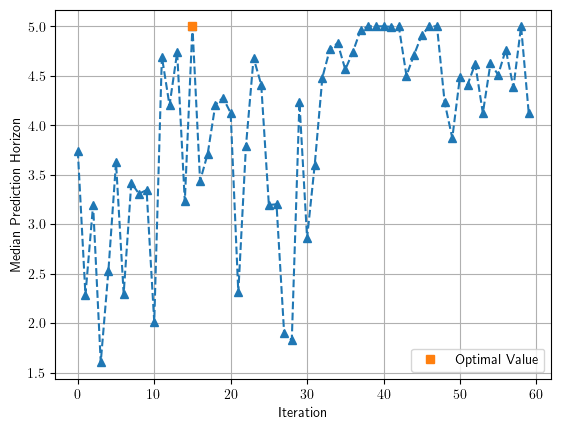

In [40]:
plt.plot(-func_iters, '--', marker='^', label='__nolegend__')
plt.plot([optim_idx], [-func_iters[optim_idx]], 's', label='Optimal Value')
plt.xlabel('Iteration')
plt.ylabel('Median Prediction Horizon')
plt.grid(True)
plt.legend()

plt.savefig(dir_name_rnn_plots+'/median_PH.png', bbox_inches='tight', dpi=300)
plt.show()

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

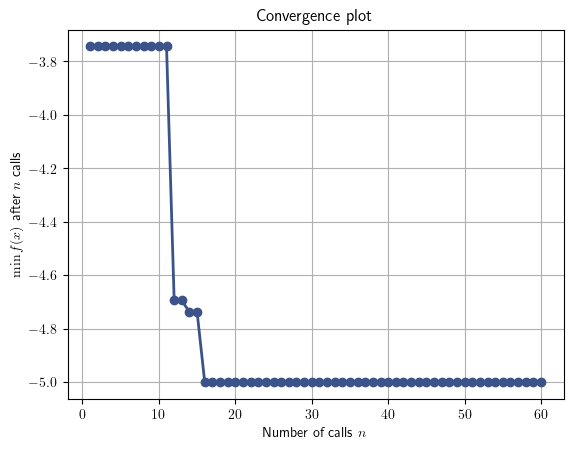

In [41]:
from skopt.plots import plot_convergence
plot_convergence(res)

In [42]:
optimized_vals_dict = {
    'x_iters':x_iters,
    'func_iters':func_iters,
    'optim_x':optim_x,
    'optim_idx':optim_idx,
    'optim_fun':func_iters[optim_idx]
}

with open(dir_name_rnn+'/optimized_vals.txt', 'w') as f:
    f.write(str(optimized_vals_dict))
    
np.savez(
    dir_name_rnn+'/optimized_vals',
    x_iters=x_iters,
    func_iters=func_iters,
    optim_x=optim_x,
    optim_idx=optim_idx,
    optim_fun=func_iters[optim_idx]
)

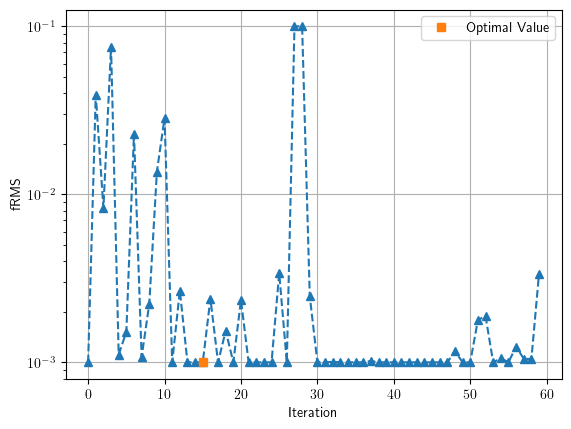

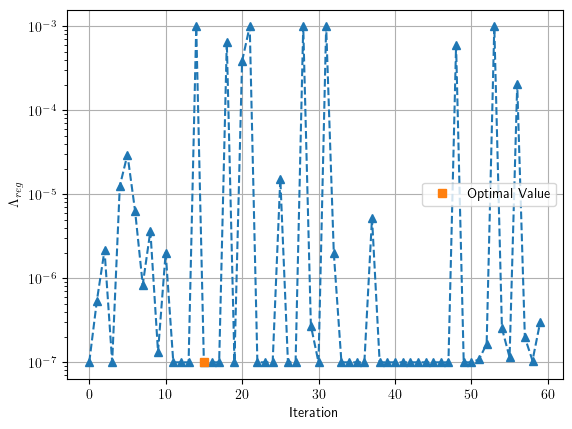

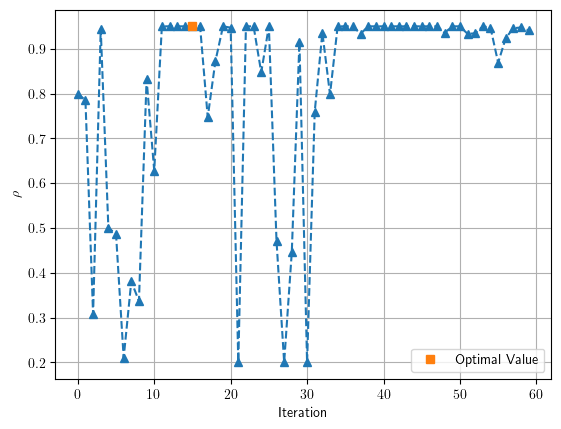

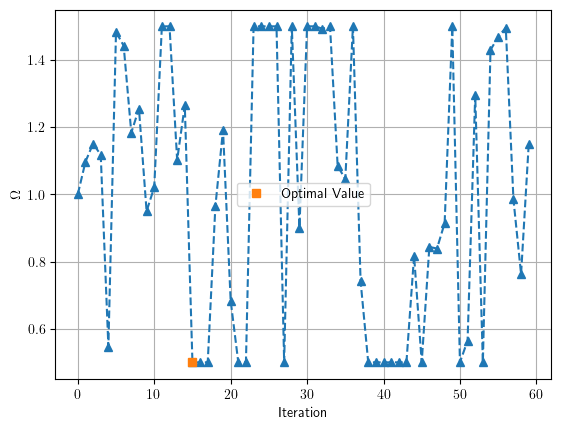

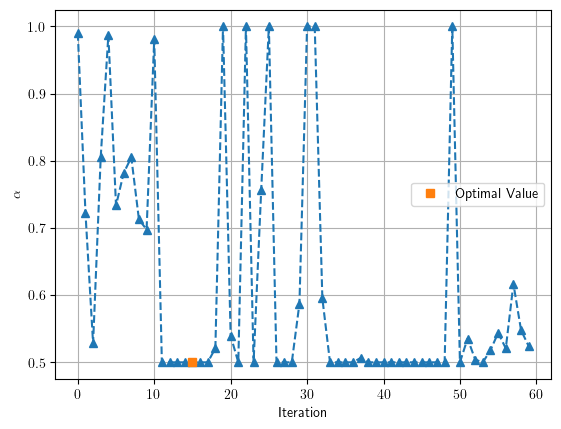

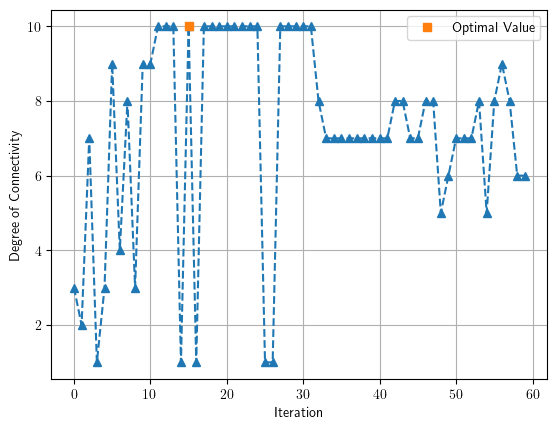

In [43]:
xoptim_names = [
    [r'fRMS', 'fRMS', plt.semilogy],
    [r'$\Lambda_{reg}$', 'lambda_reg', plt.semilogy],
    [r'$\rho$', 'rho', plt.plot],
    [r'$\Omega$', 'omega', plt.plot],
    [r'$\alpha$', 'alpha', plt.plot],
    [r'Degree of Connectivity', 'deg_of_connectivity', plt.plot],
]

for i in range(len(xoptim_names)):
    xoptim_names[i][2](x_iters[:, i], '--', marker='^', label='__nolegend__')
    xoptim_names[i][2]([optim_idx], [x_iters[optim_idx, i]], 's', label='Optimal Value')
    plt.xlabel('Iteration')
    plt.ylabel(xoptim_names[i][0])
    plt.grid(True)
    plt.legend()

    plt.savefig(dir_name_rnn_plots+'/'+xoptim_names[i][1]+'.png', bbox_inches='tight', dpi=300)
    plt.show()

In [44]:
dir_list = os.listdir(dir_name_rnn+'/tested_ESN')
# dir_list

In [45]:
ph_mean_lst = []
for dir_name in dir_list:
    with np.load(dir_name_rnn+'/tested_ESN/'+dir_name+'/prediction_horizons-testingdata.npz') as f:
        ph_mean = np.mean(f['prediction_horizon_arr'])
        ph_mean_lst.append(ph_mean)
ph_mean_lst = np.array(ph_mean_lst)

In [46]:
idx = np.where(ph_mean_lst == ph_mean_lst.max())[0]

In [47]:
idx, dir_list[idx[0]]

(array([56]), 'test_ESN_042')

### Prediction horizon computation